# Telco Customer Churn Prediction - Model Development

This is the third and final notebook in a series of notebooks developing a machine learning model to predict customer churn for a telecommunications company. In the previous notebooks, I cleaned and merged the excel files provided in [IBM's sample datasets](https://accelerator.ca.analytics.ibm.com/bi/?perspective=authoring&pathRef=.public_folders%2FIBM%2BAccelerator%2BCatalog%2FContent%2FDAT00148&id=i9710CF25EF75468D95FFFC7D57D45204&objRef=i9710CF25EF75468D95FFFC7D57D45204&action=run&format=HTML&cmPropStr=%7B%22id%22%3A%22i9710CF25EF75468D95FFFC7D57D45204%22%2C%22type%22%3A%22reportView%22%2C%22defaultName%22%3A%22DAT00148%22%2C%22permissions%22%3A%5B%22execute%22%2C%22read%22%2C%22traverse%22%5D%7D) into a single CSV file containing a consolidated dataset, examined and transformed the dataset features thoroughly and prepared the dataset for the modeling stage.

In this notebook, I will:

- Create preprocessing and modeling pipelines

- Compare baseline models with cross-validation, and alternative class imbalance techniques

- Approach the business problem from three different perspectives, focusing on F1 score, precision and rrecall separately

- Perform light tuning on models to select most promising ones on each metric

- Perform extensive hyperparameter search each model and business objective

- Measure performance of final models on the test set including classification reports, confusion matrices and ROC curve visualizations

- Analyze feature importance and compare results with visualizations from the previous notebook

- Summarize model performance with key drivers of customer churn

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, RandomizedSearchCV
from sklearn.base import clone
from sklearn.metrics import make_scorer, f1_score, precision_score, recall_score, accuracy_score, roc_auc_score, classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve

import xgboost as xgb
import lightgbm as lgb

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

import shap

pd.set_option('display.max_columns', None)

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## 1. Loading and inspecting data

In [3]:
telco = pd.read_csv("../data/processed/telco_cleaned.csv", index_col=0)

print(f"Shape: {telco.shape}")
telco.head()

Shape: (7043, 29)


,gender,age,married,number_of_dependents,number_of_referrals,tenure_in_months,offer,phone_service,avg_monthly_long_distance_charges,multiple_lines,internet_type,avg_monthly_gb_download,online_security,online_backup,device_protection_plan,premium_tech_support,streaming_tv,unlimited_data,contract,paperless_billing,payment_method,monthly_charge,total_refunds,total_extra_data_charges,churn_value,cltv,streaming,log_total_long_distance_charges,log_total_revenue
customer_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0002-ORFBO,Female,37,1,0,2,9,no_offer,1,42.39,0,Cable,16,0,1,0,1,1,1,One Year,1,Credit Card,65.6,0.00,0,0,2205,0,5.946755,6.883268
0003-MKNFE,Male,46,0,0,0,9,no_offer,1,10.69,1,Cable,10,0,0,0,0,0,0,Month-to-Month,0,Credit Card,59.9,38.33,10,0,5414,1,4.576874,6.415555
0004-TLHLJ,Male,50,0,0,0,4,Offer E,1,33.65,0,Fiber Optic,30,0,0,1,0,0,1,Month-to-Month,1,Bank Withdrawal,73.9,0.00,0,1,4479,0,4.909709,6.031766
0011-IGKFF,Male,78,1,0,1,13,Offer D,1,27.82,0,Fiber Optic,4,0,1,1,0,1,1,Month-to-Month,1,Bank Withdrawal,98.0,0.00,0,1,3714,0,5.893466,7.378078
0013-EXCHZ,Female,75,1,0,3,3,no_offer,1,7.38,0,Fiber Optic,11,0,0,0,1,1,1,Month-to-Month,1,Credit Card,83.9,0.00,0,1,3464,0,3.141563,5.671741


In [4]:
def cardinality(df, max_display=3):
    res = pd.DataFrame({
        'nunique': df.nunique(),
        'dtype': df.dtypes
    }).sort_values(by='nunique')

    res['unique_values'] = [
        df[col].unique().tolist() if res.loc[col, 'nunique'] <= max_display
        else f"[{', '.join(map(str, df[col].unique()[:max_display]))} ...(cont'd)]"
        for col in res.index
    ]

    res['missing_value_count'] = [
        df[col].isna().sum() for col in df.columns
    ]

    return res

cardinality(telco)

,nunique,dtype,unique_values,missing_value_count
gender,2,object,"[Female, Male]",0
streaming,2,int64,"[0, 1]",0
churn_value,2,int64,"[0, 1]",0
paperless_billing,2,int64,"[1, 0]",0
unlimited_data,2,int64,"[1, 0]",0
streaming_tv,2,int64,"[1, 0]",0
premium_tech_support,2,int64,"[1, 0]",0
online_backup,2,int64,"[1, 0]",0
online_security,2,int64,"[0, 1]",0
device_protection_plan,2,int64,"[0, 1]",0


## 2. Creating a preprocessing pipeline

In [5]:
# Separate target variable
X = telco.drop(['churn_value'], axis=1)
y = telco['churn_value']

# Separate dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")

print("\nChurn distribution before splitting:")
print(y.value_counts(normalize=True + 100) * 100)

print("\nTraining set churn distribution:")
print(pd.Series(y_train).value_counts(normalize=True) * 100)

print("\nTest set churn distribution:")
print(pd.Series(y_test).value_counts(normalize=True) * 100)

Training set size: 5634 samples
Test set size: 1409 samples

Churn distribution before splitting:
churn_value
0    73.463013
1    26.536987
Name: proportion, dtype: float64

Training set churn distribution:
churn_value
0    73.464679
1    26.535321
Name: proportion, dtype: float64

Test set churn distribution:
churn_value
0    73.456352
1    26.543648
Name: proportion, dtype: float64


In [6]:
# Identify numerical and categorical features for preprocessing
cat_features = X.select_dtypes(include=['object']).columns.to_list()
num_features = X.select_dtypes(include=['int64', 'float64']).columns.to_list()

print(f"Categorical features ({len(cat_features)}):")
print(cat_features)
print(f"\nNumerical features ({len(num_features)}):")
print(num_features)

Categorical features (5):
['gender', 'offer', 'internet_type', 'contract', 'payment_method']

Numerical features (23):
['age', 'married', 'number_of_dependents', 'number_of_referrals', 'tenure_in_months', 'phone_service', 'avg_monthly_long_distance_charges', 'multiple_lines', 'avg_monthly_gb_download', 'online_security', 'online_backup', 'device_protection_plan', 'premium_tech_support', 'streaming_tv', 'unlimited_data', 'paperless_billing', 'monthly_charge', 'total_refunds', 'total_extra_data_charges', 'cltv', 'streaming', 'log_total_long_distance_charges', 'log_total_revenue']


In [7]:
# Standard scaling for numerical features
num_tr = Pipeline([
    ('scaler', StandardScaler())
])

# One-hot encoding for categorical features
cat_tr = Pipeline([
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
])

# Combine both in a preprocessor
preprocessor = ColumnTransformer([
    ('num', num_tr, num_features),
    ('cat', cat_tr, cat_features)
])

Note that while tree-based models aren't affected by scaling, it doesn't harm them, and maintaining a consistent preprocessing pipeline is cleaner.

## 3. Baseline models and handling class imbalance

In this section, I'll perform an inital evaluation on several baseline models based on their precision, recall and F1 scores via cross-validation. I'll consider two methods to tackle class imbalance: Classs weights and SMOTE. I'll combine the results of these experiments in a dataframe for better comparison.

I'll start by setting up a stratified k-fold which maintains the same class distribution in each fold, and custom scorers which give more flexibility for cross-validation and hyperparameter search processes. Note that `zero_division=0` assigns a precision of 0 when no positive samples are predicted.

In [8]:
# Set up cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Custome scorers fto use within pipelines
f1_scorer = make_scorer(f1_score)
precision_scorer = make_scorer(precision_score, zero_division=0)
recall_scorer = make_scorer(recall_score)

## 3.1 Baseline model fit

In [9]:
models = {
    'Logistic Regression': Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(max_iter=1000, random_state=42))
    ]),
    
    'Linear SVM': Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', LinearSVC(random_state=42, max_iter=2000, dual=False))
    ]),
    
    'Decision Tree': Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', DecisionTreeClassifier(random_state=42))
    ]),
    
    'Random Forest': Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(random_state=42, n_jobs=-1))
    ]),
    
    'XGBoost': Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', xgb.XGBClassifier(random_state=42, eval_metric='logloss', n_jobs=-1))
    ]),
    
    'Light GBM': Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', lgb.LGBMClassifier(random_state=42, verbose=-1))
    ]),
    
    'KNN': Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', KNeighborsClassifier(n_jobs=-1))
    ]),
    
    'Naive Bayes': Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', GaussianNB())
    ])
}


# Evaluate baseline models
results = {}
for name, model in models.items():
    scores_f1 = cross_val_score(model, X, y, cv=cv, scoring=f1_scorer, n_jobs=-1)
    scores_precision = cross_val_score(model, X, y, cv=cv, scoring=precision_scorer, n_jobs=-1)
    scores_recall = cross_val_score(model, X, y, cv=cv, scoring=recall_scorer, n_jobs=-1)

    results[name] = {
        'mean_f1': scores_f1.mean(),
        'std_f1': scores_f1.std(),
        'mean_precision': scores_precision.mean(),
        'std_precision': scores_precision.std(),
        'mean_recall': scores_recall.mean(),
        'std_recall': scores_recall.std()
    }

In [10]:
# Convert results to DataFrame for easier comparison
results_df = pd.DataFrame.from_dict(results, orient='index')
results_df

,mean_f1,std_f1,mean_precision,std_precision,mean_recall,std_recall
Logistic Regression,0.691165,0.007773,0.720923,0.020166,0.664514,0.016718
Linear SVM,0.688844,0.007279,0.716662,0.019690,0.663978,0.019136
Decision Tree,0.576750,0.019925,0.576449,0.013452,0.577301,0.027586
Random Forest,0.658425,0.013537,0.737548,0.012407,0.594955,0.019523
XGBoost,0.679385,0.011638,0.712710,0.010947,0.649528,0.021368
Light GBM,0.691415,0.005602,0.729296,0.021071,0.658101,0.016445
KNN,0.596964,0.014018,0.608582,0.010457,0.585886,0.018244
Naive Bayes,0.671586,0.008272,0.581124,0.012289,0.795614,0.002584


## 3.2 Models with balanced class weights

Most models have a `class_weight` parameter. For XGBoost and LightGBM I'll calculate `scale_pos_weight` manually. I'll skip gradient boosting, KNN and naive Bayes in this section as they don't have a direct class weight parameter.

In [11]:
balanced_models = {
    'Balanced Logistic Regression': Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced'))
    ]),
    
    'Balanced Linear SVM': Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', LinearSVC(random_state=42, max_iter=2000, class_weight='balanced', dual=False))
    ]),
    
    'Balanced Decision Tree': Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', DecisionTreeClassifier(random_state=42, class_weight='balanced'))
    ]),
    
    'Balanced Random Forest': Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(random_state=42, class_weight='balanced', n_jobs=-1))
    ]),
    
    'Balanced XGBoost': Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', xgb.XGBClassifier(
            random_state=42, 
            eval_metric='logloss',
            # Control the balance of positive and negative weights, useful for unbalanced classes. A typical value to consider: sum(negative instances) / sum(positive instances). (source: https://xgboost.readthedocs.io/en/latest/parameter.html)
            scale_pos_weight=(len(y_train) - sum(y_train))/sum(y_train),
            n_jobs=-1
        ))
    ]),

    'Balanced Light GBM': Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', lgb.LGBMClassifier(
            random_state=42,
            verbose=-1,
            scale_pos_weight=(len(y_train) - sum(y_train))/sum(y_train),
            n_jobs=-1
        ))
    ])
}

# Evaluate models with balanced class weights
balanced_results = {}
for name, model in balanced_models.items():
    scores_f1 = cross_val_score(model, X, y, cv=cv, scoring=f1_scorer, n_jobs=-1)
    scores_precision = cross_val_score(model, X, y, cv=cv, scoring=precision_scorer, n_jobs=-1)
    scores_recall = cross_val_score(model, X, y, cv=cv, scoring=recall_scorer, n_jobs=-1)

    balanced_results[name] = {
        'mean_f1': scores_f1.mean(),
        'std_f1': scores_f1.std(),
        'mean_precision': scores_precision.mean(),
        'std_precision': scores_precision.std(),
        'mean_recall': scores_recall.mean(),
        'std_recall': scores_recall.std()
    }

In [12]:
# Convert results to DataFrame for easier comparison
balanced_results_df = pd.DataFrame.from_dict(balanced_results, orient='index')
balanced_results_df

,mean_f1,std_f1,mean_precision,std_precision,mean_recall,std_recall
Balanced Logistic Regression,0.690656,0.007800,0.583714,0.012256,0.845903,0.006096
Balanced Linear SVM,0.684173,0.010312,0.572122,0.014882,0.851251,0.007037
Balanced Decision Tree,0.580355,0.016311,0.587791,0.013076,0.573575,0.025244
Balanced Random Forest,0.656719,0.016702,0.746422,0.006760,0.586925,0.027622
Balanced XGBoost,0.691363,0.005507,0.664543,0.011470,0.721230,0.021707
Balanced Light GBM,0.705441,0.013628,0.637978,0.015665,0.789186,0.017845


## 3.3 SMOTE resampling

In order to avoid data leakage, I'll integrate SMOTE resampler into the pipeline that contains preprocessing and the model.

In [13]:
smote_models = {
    'SMOTE Logistic Regression': ImbPipeline([
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('classifier', LogisticRegression(max_iter=1000, random_state=42))
    ]),
    
    'SMOTE Linear SVM': ImbPipeline([
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('classifier', LinearSVC(random_state=42, max_iter=2000, dual=False))
    ]),
    
    'SMOTE Decision Tree': ImbPipeline([
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('classifier', DecisionTreeClassifier(random_state=42))
    ]),
    
    'SMOTE Random Forest': ImbPipeline([
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('classifier', RandomForestClassifier(random_state=42, n_jobs=-1))
    ]),
    
    'SMOTE XGBoost': ImbPipeline([
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('classifier', xgb.XGBClassifier(random_state=42, eval_metric='logloss', n_jobs=-1))
    ]),
    
    'SMOTE Light GBM': ImbPipeline([
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('classifier', lgb.LGBMClassifier(random_state=42, verbose=-1))
    ]),

    'SMOTE KNN': ImbPipeline([
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('classifier', KNeighborsClassifier(n_jobs=-1))
    ]),
    
    'SMOTE Naive Bayes': ImbPipeline([
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('classifier', GaussianNB())
    ])
}

# Evaluate SMOTE models
smote_results = {}
for name, model in smote_models.items():
    scores_f1 = cross_val_score(model, X, y, cv=cv, scoring=f1_scorer, n_jobs=-1)
    scores_precision = cross_val_score(model, X, y, cv=cv, scoring=precision_scorer, n_jobs=-1)
    scores_recall = cross_val_score(model, X, y, cv=cv, scoring=recall_scorer, n_jobs=-1)

    smote_results[name] = {
        'mean_f1': scores_f1.mean(),
        'std_f1': scores_f1.std(),
        'mean_precision': scores_precision.mean(),
        'std_precision': scores_precision.std(),
        'mean_recall': scores_recall.mean(),
        'std_recall': scores_recall.std()
    }

In [14]:
# Convert results to DataFrame for easier comparison
smote_results_df = pd.DataFrame.from_dict(smote_results, orient='index')
smote_results_df

,mean_f1,std_f1,mean_precision,std_precision,mean_recall,std_recall
SMOTE Logistic Regression,0.692676,0.008247,0.591951,0.014041,0.835197,0.009072
SMOTE Linear SVM,0.686048,0.008418,0.580274,0.014195,0.839479,0.008089
SMOTE Decision Tree,0.598763,0.017827,0.577783,0.013866,0.621701,0.026672
SMOTE Random Forest,0.688720,0.012237,0.698832,0.019194,0.679500,0.018769
SMOTE XGBoost,0.680753,0.010406,0.692836,0.018447,0.669869,0.020889
SMOTE Light GBM,0.692267,0.009950,0.702615,0.025826,0.683239,0.016390
SMOTE KNN,0.590754,0.013432,0.470760,0.010092,0.792938,0.021493
SMOTE Naive Bayes,0.667967,0.007764,0.577174,0.012218,0.792936,0.006037


## 3.4 Combine scores from all experiments

In [15]:
# Combine all results
all_results = pd.concat([results_df, balanced_results_df, smote_results_df])

print("Best models on F1-score:")
display(all_results.sort_values(by='mean_f1', ascending=False)[:5])

print("Best models on precision:")
display(all_results.sort_values(by='mean_precision', ascending=False)[:5])

print("Best models on recall:")
display(all_results.sort_values(by='mean_recall', ascending=False)[:5])

Best models on F1-score:


,mean_f1,std_f1,mean_precision,std_precision,mean_recall,std_recall
Balanced Light GBM,0.705441,0.013628,0.637978,0.015665,0.789186,0.017845
SMOTE Logistic Regression,0.692676,0.008247,0.591951,0.014041,0.835197,0.009072
SMOTE Light GBM,0.692267,0.009950,0.702615,0.025826,0.683239,0.016390
Light GBM,0.691415,0.005602,0.729296,0.021071,0.658101,0.016445
Balanced XGBoost,0.691363,0.005507,0.664543,0.011470,0.721230,0.021707


Best models on precision:


,mean_f1,std_f1,mean_precision,std_precision,mean_recall,std_recall
Balanced Random Forest,0.656719,0.016702,0.746422,0.006760,0.586925,0.027622
Random Forest,0.658425,0.013537,0.737548,0.012407,0.594955,0.019523
Light GBM,0.691415,0.005602,0.729296,0.021071,0.658101,0.016445
Logistic Regression,0.691165,0.007773,0.720923,0.020166,0.664514,0.016718
Linear SVM,0.688844,0.007279,0.716662,0.019690,0.663978,0.019136


Best models on recall:


,mean_f1,std_f1,mean_precision,std_precision,mean_recall,std_recall
Balanced Linear SVM,0.684173,0.010312,0.572122,0.014882,0.851251,0.007037
Balanced Logistic Regression,0.690656,0.007800,0.583714,0.012256,0.845903,0.006096
SMOTE Linear SVM,0.686048,0.008418,0.580274,0.014195,0.839479,0.008089
SMOTE Logistic Regression,0.692676,0.008247,0.591951,0.014041,0.835197,0.009072
Naive Bayes,0.671586,0.008272,0.581124,0.012289,0.795614,0.002584


## 4. Modeling strategy

This project's ultimate goal is to build prediction models for customer churn and interpret which features are important in this process. The business problem can be approached from several perspectives:

- **Recall-focused approach**: Prioritizing catching as many potential churners as possible, minimizing false negatives. This is valuable when the cost of missing a churner is high.

- **Precision-focused approach**: Prioritizing identifying true churners with fewer false alarms, minimizing false positives. This is valuable when intervention resources are limited.

- **Balanced approach**: Optimizing for overall model performance by balancing false positives and false negatives, measured by F1-score.

### Approach

I'll implement a two-stage hyperparameter tuning process:

1. **Initial Light Tuning**: Perform a lightweight hyperparameter search on all models to get a better sense of their potential.

2. **Extensive Tuning**: Select the most promising models based on the initial tuning results, then perform a more extensive hyperparameter search.

For class imbalance handling, I'll use class weights since:
- The target imbalance is not severe (approximately 27% to 73%)
- The experiment results don't show SMOTE providing significantly better performance
- Class weights preserve the original data distribution while addressing the imbalance

## 5. Initial light hyperparameter tuning

In this section, I'll perform a lightweight hyperparameter search to find the best models optimized for F1 score, precision and recall. I'll set aside a validation set to inspect the results of the tuning more objectively.

In [16]:
# Separate training set to set aside a validation set
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

print(f"Second (after split) training set size: {X_tr.shape[0]} samples")
print(f"Validation set size: {X_val.shape[0]} samples")

print("\nChurn distribution in the inital training set before split:")
print(y_train.value_counts(normalize=True) * 100)

print("\nChurn distribution in the second training set after split:")
print(pd.Series(y_tr).value_counts(normalize=True) * 100)

print("\nValidation set churn distribution:")
print(pd.Series(y_val).value_counts(normalize=True) * 100)

Second (after split) training set size: 4507 samples
Validation set size: 1127 samples

Churn distribution in the inital training set before split:
churn_value
0    73.464679
1    26.535321
Name: proportion, dtype: float64

Churn distribution in the second training set after split:
churn_value
0    73.463501
1    26.536499
Name: proportion, dtype: float64

Validation set churn distribution:
churn_value
0    73.469388
1    26.530612
Name: proportion, dtype: float64


In [17]:
# Helper function for light hyperparameter tuning
def light_tune_model(model_class, param_grid, scoring, model_name):
    """
    Performs lightweight hyperparameter tuning for a model
    """
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model_class)
    ])

    # Simpler stratified cross-validation for the inner training set
    cv_inner = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    
    grid_search = RandomizedSearchCV(
        pipeline,
        param_distributions=param_grid,
        n_iter=5,  # Reduced iterations for lightweight search
        scoring=scoring,
        cv=cv_inner,
        random_state=42,
        n_jobs=-1,
        verbose=0
    )
    
    grid_search.fit(X_tr, y_tr)
    y_val_pred = grid_search.predict(X_val)
    
    return {
        'model_name': model_name,
        'best_params': grid_search.best_params_,
        'best_estimator': grid_search.best_estimator_,
        'F1 Score': f1_score(y_val, y_val_pred),
        'Precision': precision_score(y_val, y_val_pred),
        'Recall': recall_score(y_val, y_val_pred)
    }

In [18]:
# Lightweight parameter grids for each model type

pos_class_weight = (len(y_tr) - sum(y_tr))/sum(y_tr)

lr_light_params = {
    'model__C': [0.1, 1, 10],
    'model__penalty': ['l1', 'l2'],
    'model__class_weight': ['balanced', None],
    'model__solver': ['liblinear', 'saga']
}

svm_light_params = {
    'model__C': [0.1, 1, 10],
    'model__class_weight': ['balanced', None]
}

tree_light_params = {
    'model__max_depth': [5, 10, None],
    'model__min_samples_split': [2, 5],
    'model__min_samples_leaf': [1, 2],
    'model__class_weight': ['balanced', None],
    'model__criterion': ['gini', 'entropy']
}

rf_light_params = {
    'model__n_estimators': [50, 100],
    'model__max_depth': [5, 10, None],
    'model__min_samples_split': [2, 5],
    'model__class_weight': ['balanced', None],
    'model__criterion': ['gini', 'entropy']
}

xgb_light_params = {
    'model__n_estimators': [50, 100],
    'model__max_depth': [3, 5],
    'model__learning_rate': [0.01, 0.1],
    'model__subsample': [0.8, 1.0],
    'model__colsample_bytree': [0.8, 1.0],
    'model__scale_pos_weight': [1, pos_class_weight]
}

lgb_light_params = {
    'model__n_estimators': [50, 100],
    'model__max_depth': [3, 5],
    'model__learning_rate': [0.01, 0.1],
    'model__subsample': [0.8, 1.0],
    'model__colsample_bytree': [0.8, 1.0],
    'model__scale_pos_weight': [1, pos_class_weight]
}

knn_light_params = {
    'model__n_neighbors': [3, 5, 7],
    'model__weights': ['uniform', 'distance'],
    'model__algorithm': ['auto', 'ball_tree'],
    'model__leaf_size': [20, 30, 40]
}

nb_light_params = {
    'model__var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]
}


## 5.1 Perform light tuning for F1 score optimization

In [19]:
f1_light_tune_results = []

f1_light_tune_results.append(light_tune_model(
    LogisticRegression(random_state=42, max_iter=1000), 
    lr_light_params, f1_scorer, 'Logistic Regression'
))

f1_light_tune_results.append(light_tune_model(
    LinearSVC(random_state=42, dual=False, max_iter=2000), 
    svm_light_params, f1_scorer, 'Linear SVM'
))

f1_light_tune_results.append(light_tune_model(
    DecisionTreeClassifier(random_state=42), 
    tree_light_params, f1_scorer, 'Decision Tree'
))

f1_light_tune_results.append(light_tune_model(
    RandomForestClassifier(random_state=42, n_jobs=-1), 
    rf_light_params, f1_scorer, 'Random Forest'
))

f1_light_tune_results.append(light_tune_model(
    xgb.XGBClassifier(random_state=42, eval_metric='logloss', n_jobs=-1), 
    xgb_light_params, f1_scorer, 'XGBoost'
))

f1_light_tune_results.append(light_tune_model(
    lgb.LGBMClassifier(random_state=42, verbose=-1), 
    lgb_light_params, f1_scorer, 'Light GBM'
))

f1_light_tune_results.append(light_tune_model(
    KNeighborsClassifier(n_jobs=-1), 
    knn_light_params, f1_scorer, 'KNN'
))

f1_light_tune_results.append(light_tune_model(
    GaussianNB(), 
    nb_light_params, f1_scorer, 'Naive Bayes'
))

In [20]:
# Overview of scores for top 5 models optimized for F1 score
f1_light_tune_results.sort(key=lambda x: x['F1 Score'], reverse=True)

f1_model_metrics = {}
for i in range(5):
    name = f1_light_tune_results[i]['model_name']
    f1_model_metrics[name] = {
        'F1 Score': f1_light_tune_results[i]['F1 Score'],
        'Precision': f1_light_tune_results[i]['Precision'],
        'Recall': f1_light_tune_results[i]['Recall']
    }

f1_model_metrics = pd.DataFrame.from_dict(f1_model_metrics, orient='index')

print("Top 5 F1 score optimized models:")
f1_model_metrics

Top 5 F1 score optimized models:


,F1 Score,Precision,Recall
Light GBM,0.673103,0.572770,0.816054
XGBoost,0.671309,0.575179,0.806020
Linear SVM,0.665557,0.662252,0.668896
Random Forest,0.665499,0.698529,0.635452
Logistic Regression,0.649867,0.538462,0.819398


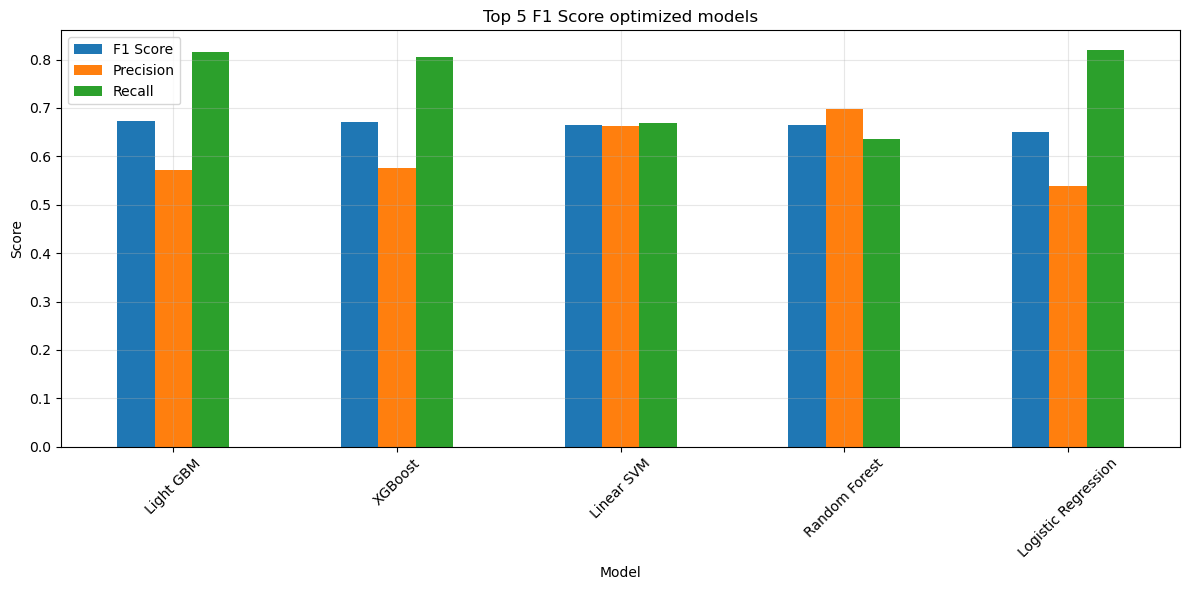

In [21]:
# Plot performance metrics
f1_model_metrics.plot(kind='bar', figsize=(12, 6))
plt.title('Top 5 F1 Score optimized models')
plt.ylabel('Score')
plt.xlabel('Model')
plt.xticks(rotation=45)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Light GBM and XGBoost are the top performers, but Linear SVM and Random Forest follow very closely and seem to be better balanced models in terms of precision and recall.

## 5.2 Perform light tuning for precision optimization

In [22]:
precision_light_tune_results = []

precision_light_tune_results.append(light_tune_model(
    LogisticRegression(random_state=42, max_iter=1000), 
    lr_light_params, precision_scorer, 'Logistic Regression'
))

precision_light_tune_results.append(light_tune_model(
    LinearSVC(random_state=42, dual=False, max_iter=2000), 
    svm_light_params, precision_scorer, 'Linear SVM'
))

precision_light_tune_results.append(light_tune_model(
    DecisionTreeClassifier(random_state=42), 
    tree_light_params, precision_scorer, 'Decision Tree'
))

precision_light_tune_results.append(light_tune_model(
    RandomForestClassifier(random_state=42, n_jobs=-1), 
    rf_light_params, precision_scorer, 'Random Forest'
))

precision_light_tune_results.append(light_tune_model(
    xgb.XGBClassifier(random_state=42, eval_metric='logloss', n_jobs=-1), 
    xgb_light_params, precision_scorer, 'XGBoost'
))

precision_light_tune_results.append(light_tune_model(
    lgb.LGBMClassifier(random_state=42, verbose=-1), 
    lgb_light_params, precision_scorer, 'Light GBM'
))

precision_light_tune_results.append(light_tune_model(
    KNeighborsClassifier(n_jobs=-1), 
    knn_light_params, precision_scorer, 'KNN'
))

precision_light_tune_results.append(light_tune_model(
    GaussianNB(), 
    nb_light_params, precision_scorer, 'Naive Bayes'
))

In [23]:
# Overview of scores for top 5 models optimized for Precision
precision_light_tune_results.sort(key=lambda x: x['Precision'], reverse=True)

precision_model_metrics = {}
for i in range(5):
    name = precision_light_tune_results[i]['model_name']
    precision_model_metrics[name] = {
        'F1 Score': precision_light_tune_results[i]['F1 Score'],
        'Precision': precision_light_tune_results[i]['Precision'],
        'Recall': precision_light_tune_results[i]['Recall']
    }

precision_model_metrics = pd.DataFrame.from_dict(precision_model_metrics, orient='index')

print("Top 5 Precision optimized models:")
precision_model_metrics

Top 5 Precision optimized models:


,F1 Score,Precision,Recall
XGBoost,0.208333,0.945946,0.117057
Light GBM,0.208333,0.945946,0.117057
Linear SVM,0.665557,0.662252,0.668896
Random Forest,0.550781,0.661972,0.471572
Decision Tree,0.630137,0.645614,0.615385


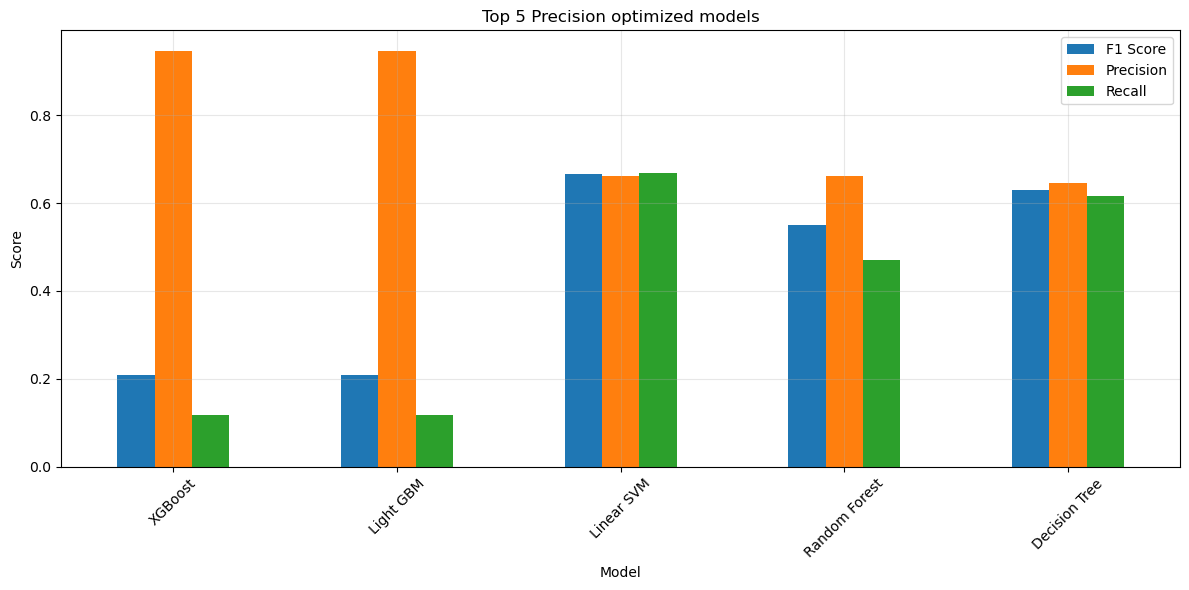

In [24]:
# Plot performance metrics
precision_model_metrics.plot(kind='bar', figsize=(12, 6))
plt.title('Top 5 Precision optimized models')
plt.ylabel('Score')
plt.xlabel('Model')
plt.xticks(rotation=45)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Although XGBoost and Light BGM perform exceptionally better than the other models on precision, this is misleading and comes at the cost of terrible recall performances. The precision-optimized top 2 models correctly identify only about 12% of the churners, which suggests that precision-optimization pushes the model to almost never predict positive (churn). These models are not useful.

Precision optimized Linear SVM, at the third place, seems to perform very similarly to its F1 score optimized version; all three metrics are balanced and are around 0.66 each.

## 5.3 Perform light tuning for recall optimization

In [25]:
recall_light_tune_results = []

recall_light_tune_results.append(light_tune_model(
    LogisticRegression(random_state=42, max_iter=1000), 
    lr_light_params, recall_scorer, 'Logistic Regression'
))

recall_light_tune_results.append(light_tune_model(
    LinearSVC(random_state=42, dual=False, max_iter=2000), 
    svm_light_params, recall_scorer, 'Linear SVM'
))

recall_light_tune_results.append(light_tune_model(
    DecisionTreeClassifier(random_state=42), 
    tree_light_params, recall_scorer, 'Decision Tree'
))

recall_light_tune_results.append(light_tune_model(
    RandomForestClassifier(random_state=42, n_jobs=-1), 
    rf_light_params, recall_scorer, 'Random Forest'
))

recall_light_tune_results.append(light_tune_model(
    xgb.XGBClassifier(random_state=42, eval_metric='logloss', n_jobs=-1), 
    xgb_light_params, recall_scorer, 'XGBoost'
))

recall_light_tune_results.append(light_tune_model(
    lgb.LGBMClassifier(random_state=42, verbose=-1), 
    lgb_light_params, recall_scorer, 'Light GBM'
))

recall_light_tune_results.append(light_tune_model(
    KNeighborsClassifier(n_jobs=-1), 
    knn_light_params, recall_scorer, 'KNN'
))

recall_light_tune_results.append(light_tune_model(
    GaussianNB(), 
    nb_light_params, recall_scorer, 'Naive Bayes'
))

In [26]:
# Overview of scores for top 5 models optimized for Recall
recall_light_tune_results.sort(key=lambda x: x['Recall'], reverse=True)

recall_model_metrics = {}
for i in range(5):
    name = recall_light_tune_results[i]['model_name']
    recall_model_metrics[name] = {
        'F1 Score': recall_light_tune_results[i]['F1 Score'],
        'Precision': recall_light_tune_results[i]['Precision'],
        'Recall': recall_light_tune_results[i]['Recall']
    }

recall_model_metrics = pd.DataFrame.from_dict(recall_model_metrics, orient='index')

print("Top 5 Recall optimized models:")
recall_model_metrics

Top 5 Recall optimized models:


,F1 Score,Precision,Recall
Linear SVM,0.651715,0.538126,0.826087
Logistic Regression,0.649867,0.538462,0.819398
Light GBM,0.673103,0.572770,0.816054
XGBoost,0.671309,0.575179,0.806020
Naive Bayes,0.627286,0.541262,0.745819


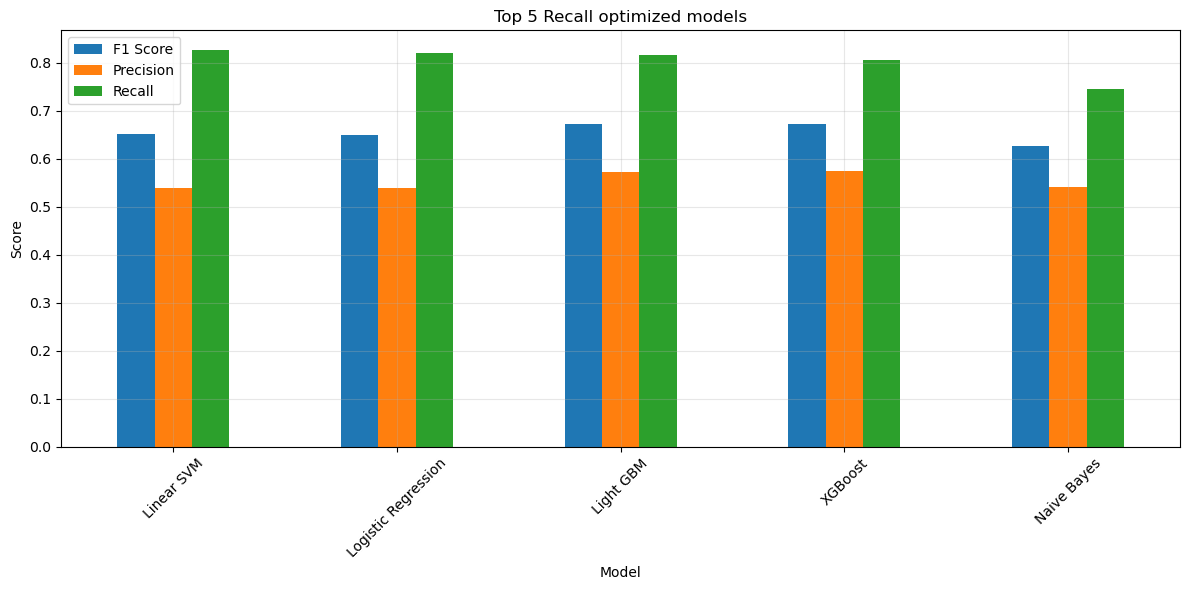

In [27]:
# Plot performance metrics
recall_model_metrics.plot(kind='bar', figsize=(12, 6))
plt.title('Top 5 Recall optimized models')
plt.ylabel('Score')
plt.xlabel('Model')
plt.xticks(rotation=45)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

The top performances of recall-optimized models are similar to the F1 optimized top performers, and don't provide new insights; the recall of the top F1 performers were already strong around 80%.

### Analyzing results

- F1 optimized Light GBM, XGBoost and Linear SVM seem to be the most promising models; the two boosting models have slightly higher F1 score, but Linear SVM is the most balanced one across three metrics.

- Optimizing for precision does not produce useful results, and optimizing for recall does not provide anything new compared to F1 score optimization.

### Next steps

- Based on these observations, my aim is to obtain the best balanced model using hyperparameter tuning. I'll perform extensive hyperparameter search on Light GBM, XGBoost and Linear SVM while optimizing for F1 score and inspecting performance on all three metrics.

- Since optimization for precision/recall does not produce useful results, I'll address the different business objectives using a different technique, namely, threshold adjustment which provides a more flexible approach.

## 6. Extensive hyperparameter tuning for selected models

I'll start by setting up a helper function and parameter grids for extensive tuning.

In [ ]:
# Helper function for extensive hyperparameter tuning
def extensive_tune_model(model_class, param_grid, scoring, model_name):
    """
    Performs extensive hyperparameter tuning for a model
    """
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model_class)
    ])

    # Simpler stratified cross-validation for the inner training set
    cv_inner = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    
    grid_search = RandomizedSearchCV(
        pipeline,
        param_distributions=param_grid,
        n_iter=100,  # Increased iterations for extensive search
        scoring=scoring,
        cv=cv_inner,
        random_state=42,
        n_jobs=-1,
        verbose=0
    )
    
    grid_search.fit(X_tr, y_tr)
    y_val_pred = grid_search.predict(X_val)
    
    return {
        'model_name': model_name,
        'best_params': grid_search.best_params_,
        'best_estimator': grid_search.best_estimator_,
        'F1 Score': f1_score(y_val, y_val_pred),
        'Precision': precision_score(y_val, y_val_pred),
        'Recall': recall_score(y_val, y_val_pred)
    }

In [29]:
# Extensive parameter grids for selected models

pos_class_weight = (len(y_tr) - sum(y_tr))/sum(y_tr)

svm_extensive_params = {
    'model__C': [0.01, 0.1, 1, 10, 100],
    'model__penalty': ['l1', 'l2'],
    'model__tol': [1e-4, 1e-5],
    'model__class_weight': ['balanced', None],
    'model__max_iter': [2000, 4000, 6000]
}

xgb_extensive_params = {
    'model__n_estimators': [100, 200],
    'model__learning_rate': [0.005, 0.01, 0.05, 0.1],
    'model__max_depth': [3, 5, 7, 10],
    'model__subsample': [0.8, 1.0],
    'model__colsample_bytree': [0.8, 1.0],
    'model__reg_alpha': [0, 1],
    'model__reg_lambda': [0, 1],
    'model__scale_pos_weight': [1, pos_class_weight]
}

lgb_extensive_params = {
    'model__n_estimators': [100, 200],
    'model__learning_rate': [0.005, 0.01, 0.05, 0.1],
    'model__max_depth': [-1, 3, 5, 7],
    'model__num_leaves': [15, 31, 63], # upper bd: 2^{max_depth}
    'model__subsample': [0.8, 1.0],
    'model__colsample_bytree': [0.8, 1.0],
    'model__reg_alpha': [0, 1],
    'model__reg_lambda': [0, 1],
    'model__scale_pos_weight': [1, pos_class_weight]
}

## 6.1 Perform extensive tuning on top 3 models

In this section, my goal is to obtain the best balanced model using F1 score on the validation set.

In [30]:
extensive_tune_results = []

extensive_tune_results.append(extensive_tune_model(
    LinearSVC(random_state=42, dual=False), 
    svm_extensive_params, f1_scorer, 'Linear SVM'
))

extensive_tune_results.append(extensive_tune_model(
    xgb.XGBClassifier(random_state=42, eval_metric='logloss', n_jobs=-1), 
    xgb_extensive_params, f1_scorer, 'XGBoost'
))

extensive_tune_results.append(extensive_tune_model(
    lgb.LGBMClassifier(random_state=42, verbose=-1), 
    lgb_extensive_params, f1_scorer, 'Light GBM'
))

In [31]:
# Overview of scores for top 3 models
extensive_tune_results.sort(key=lambda x: x['F1 Score'], reverse=True)

extensive_model_metrics = {}
for i in range(3):
    name = extensive_tune_results[i]['model_name']
    extensive_model_metrics[name] = {
        'F1 Score': extensive_tune_results[i]['F1 Score'],
        'Precision': extensive_tune_results[i]['Precision'],
        'Recall': extensive_tune_results[i]['Recall']
    }

extensive_model_metrics = pd.DataFrame.from_dict(extensive_model_metrics, orient='index')

print("Top 3 models (F1 Score optimized):")
extensive_model_metrics

Top 3 models (F1 Score optimized):


,F1 Score,Precision,Recall
XGBoost,0.688857,0.607143,0.795987
Light GBM,0.682788,0.594059,0.802676
Linear SVM,0.675541,0.672185,0.678930


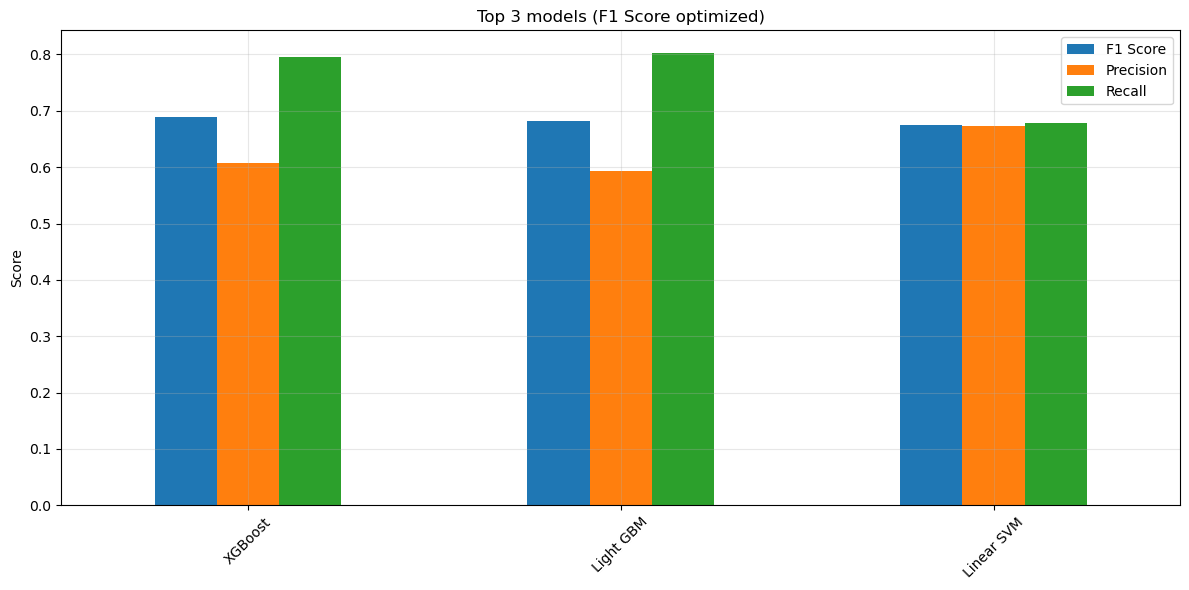

In [32]:
# Plot performance metrics
extensive_model_metrics.plot(kind='bar', figsize=(12, 6))
plt.title('Top 3 models (F1 Score optimized)')
plt.ylabel('Score')
plt.xlabel('')
plt.xticks(rotation=45)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

- Top F1 scores are very close ~0.68. Linear SVM is exceptionally balanced across three metrics ~0.67 where XGBoost and Light GBM perform similarly with recall ~0.80 and precision ~0.60.

- I'll choose XGBoost as the primary model (Light GBM works for the same reasons) as:
    - It has the highest F1 score
    - It gives probabilistic outputs (`predict_proba`) which allows threshold adjustment for precision-recall trade-offs

- Linear SVM is a strong complementary model as:
    - It provides a simple lightweight solution
    - It has naturally balanced precision and recall

In [33]:
# The best XGBoost model
print(extensive_tune_results[0]['model_name'])
best_xgb = extensive_tune_results[0]['best_estimator']

XGBoost


In [34]:
# The complementary Linear SVC model
print(extensive_tune_results[2]['model_name'])
best_svc = extensive_tune_results[2]['best_estimator']

Linear SVM


## 7. Threshold adjustment

In this section, I'll use threshold asjustment on the best XGBoost model to study precision or recall-focused business objectives, as well as to find the optimal threshold for F1 score.

Note that I'll get probabilities and discuss threshold adjustment on the validation data. We'll consider final evaluation on test data only after we've finalized our model and thresholds.

In [35]:
# Get positive prediction probabilities on validation set
y_val_prob = best_xgb.predict_proba(X_val)[:, 1]

precisions, recalls, thresholds = precision_recall_curve(y_val, y_val_prob)

## 7.1 Default threshold

Let's first evaluate the performance using the default threshold of 0.5 to establish a baseline.

In [36]:
default_threshold = 0.5
y_val_pred_default = (y_val_prob >= default_threshold).astype(int)

# Calculate confusion matrix for default threshold
tn_default, fp_default, fn_default, tp_default = confusion_matrix(y_val, y_val_pred_default).ravel()

threshold_metrics = {}
threshold_metrics['XGBoost default threshold (0.5)'] = {
    'F1 Score': f1_score(y_val, y_val_pred_default),
    'Precision': precision_score(y_val, y_val_pred_default),
    'Recall': recall_score(y_val, y_val_pred_default),
    'TP': tp_default,
    'FP': fp_default,
    'TN': tn_default,
    'FN': fn_default
}

pd.DataFrame.from_dict(threshold_metrics, orient='index')

,F1 Score,Precision,Recall,TP,FP,TN,FN
XGBoost default threshold (0.5),0.688857,0.607143,0.795987,238,154,674,61


## 7.2 Balanced approach

In order to adjust the threshold in the balanced approach, I'll calculate the F1 scores using the precision and recall values, and choose the optimal threshold that results in the maximum F1 score, using the values from the output of `precision_recall_curve` above.

*Note: Maximizing F1 score seeks the optimal trade-off between precision and recall, but doesn't necessarily result in equal values for both metrics. F1 is the harmonic mean of precision and recall, which penalizes when either value is low. In general, the optimal F1 threshold might still favor one metric over the other.*

In [37]:
# Calculate F1 score for each threshold
f1_scores = [
    2 * (p * r) / (p + r) if (p + r) > 0 else 0
    for p, r in zip(precisions[:-1], recalls[:-1])
]

# Find threshold that maximizes F1
optimal_f1_threshold_idx = np.argmax(f1_scores)
optimal_f1_threshold = thresholds[optimal_f1_threshold_idx]
optimal_f1 = f1_scores[optimal_f1_threshold_idx]

In [38]:
# View the metrics with the optimal F1 threshold
y_val_pred = (y_val_prob >= optimal_f1_threshold).astype(int)

# Calculate confusion matrix for F1-optimal threshold
tn_f1, fp_f1, fn_f1, tp_f1 = confusion_matrix(y_val, y_val_pred).ravel()

threshold_metrics['XGBoost optimal F1 threshold'] = {
    'F1 Score': f1_score(y_val, y_val_pred),
    'Precision': precision_score(y_val, y_val_pred),
    'Recall': recall_score(y_val, y_val_pred),
    'TP': tp_f1,
    'FP': fp_f1,
    'TN': tn_f1,
    'FN': fn_f1
}

pd.DataFrame.from_dict(threshold_metrics, orient='index')

,F1 Score,Precision,Recall,TP,FP,TN,FN
XGBoost default threshold (0.5),0.688857,0.607143,0.795987,238,154,674,61
XGBoost optimal F1 threshold,0.694215,0.686275,0.702341,210,96,732,89


The resulting model metrics are much more balanced, and look similar to the best Linear SVM model from the previous section which had ~0.67 for all three metrics, but this model performs better on all three.

The fact that precision and recall values are very close is a fortunate coincidence specific to our dataset and model, making this threshold particlarly appealing.

This is the model that addresses the balanced business objective with the best scores on the validation set.

## 7.3 Precision and recall-focused approaches

My goal in this section is to adjust the classification threshold to prioritize one side at a time in the precision-recall trade-off. This method is adaptive; it provides a tunable approach where the threshold can be optimized for particular performance targets.


### Recall-focused

As an example, let the business objective be:

- *Our premium retention team has limited capacity and can only reach out to a portion of our customer base. We need to identify at least 85% of potential churners to ensure we're not missing high-risk customers. Missing customers who end up churning represents significant lost revenue and acquisition costs to replace them.*

This translates to having a recall that is at least 0.85.

In [39]:
min_recall = 0.85
recall_threshold_idx = np.argmin(np.abs(recalls - min_recall))
recall_threshold = thresholds[recall_threshold_idx]
print(f"Threshold for {min_recall:.1%} recall: {recall_threshold:.3f}")
print(f"Corresponding precision: {precisions[recall_threshold_idx]:.3f}")

Threshold for 85.0% recall: 0.327
Corresponding precision: 0.516


In [40]:
# View the metrics with the recall-focused threshold
y_val_pred = (y_val_prob >= recall_threshold).astype(int)

# Calculate confusion matrix for recall-focused threshold
tn_recall, fp_recall, fn_recall, tp_recall = confusion_matrix(y_val, y_val_pred).ravel()

threshold_metrics['XGBoost recall ≥ 0.85 threshold'] = {
    'F1 Score': f1_score(y_val, y_val_pred),
    'Precision': precision_score(y_val, y_val_pred),
    'Recall': recall_score(y_val, y_val_pred),
    'TP': tp_recall,
    'FP': fp_recall,
    'TN': tn_recall,
    'FN': fn_recall
}

pd.DataFrame.from_dict(threshold_metrics, orient='index')

,F1 Score,Precision,Recall,TP,FP,TN,FN
XGBoost default threshold (0.5),0.688857,0.607143,0.795987,238,154,674,61
XGBoost optimal F1 threshold,0.694215,0.686275,0.702341,210,96,732,89
XGBoost recall ≥ 0.85 threshold,0.642225,0.516260,0.849498,254,238,590,45


### Precision-focused

In this example, let the business objective be:

- *Our retention program involves offering incentives and special offers that have real costs. We need a precision of at least 85% to ensure our retention budget is spent efficiently. False positives mean we're spending retention resources on customers who weren't planning to leave, resulting in unnecessary costs.*

This translates to having a precision that is at least 0.85.

In [41]:
min_precision = 0.85
precision_threshold_idx = np.argmin(np.abs(precisions - min_precision))
precision_threshold = thresholds[precision_threshold_idx]
print(f"Threshold for {min_precision:.1%} precision: {precision_threshold:.3f}")
print(f"Corresponding recall: {recalls[precision_threshold_idx]:.3f}")

Threshold for 85.0% precision: 0.867
Corresponding recall: 0.435


In [42]:
# View the metrics with the precision-focused threshold
y_val_pred = (y_val_prob >= precision_threshold).astype(int)

# Calculate confusion matrix for precision-focused threshold
tn_precision, fp_precision, fn_precision, tp_precision = confusion_matrix(y_val, y_val_pred).ravel()

threshold_metrics['XGBoost precision ≥ 0.85 threshold'] = {
    'F1 Score': f1_score(y_val, y_val_pred),
    'Precision': precision_score(y_val, y_val_pred),
    'Recall': recall_score(y_val, y_val_pred),
    'TP': tp_precision,
    'FP': fp_precision,
    'TN': tn_precision,
    'FN': fn_precision
}

pd.DataFrame.from_dict(threshold_metrics, orient='index')

,F1 Score,Precision,Recall,TP,FP,TN,FN
XGBoost default threshold (0.5),0.688857,0.607143,0.795987,238,154,674,61
XGBoost optimal F1 threshold,0.694215,0.686275,0.702341,210,96,732,89
XGBoost recall ≥ 0.85 threshold,0.642225,0.516260,0.849498,254,238,590,45
XGBoost precision ≥ 0.85 threshold,0.575221,0.849673,0.434783,130,23,805,169


### Plot comparison of different threshold optimization strategies

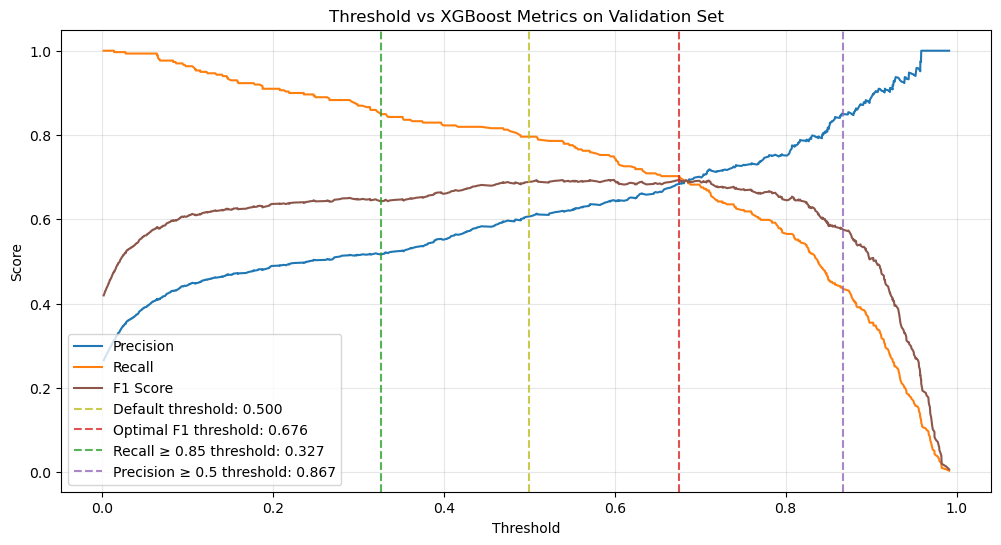

In [43]:
# Plot metrics separately
plt.figure(figsize=(12, 6))
plt.plot(thresholds, precisions[:-1], label='Precision')
plt.plot(thresholds, recalls[:-1], label='Recall')
plt.plot(thresholds, f1_scores, label='F1 Score', color='tab:brown')

plt.axvline(x=default_threshold, color='tab:olive',
            linestyle='--', alpha=0.8,
            label=f"Default threshold: {default_threshold:.3f}")

plt.axvline(x=optimal_f1_threshold, color='tab:red',
            linestyle='--', alpha=0.8,
            label=f"Optimal F1 threshold: {optimal_f1_threshold:.3f}")

plt.axvline(x=recall_threshold, color='tab:green',
            linestyle='--', alpha=0.8,
            label=f"Recall ≥ 0.85 threshold: {recall_threshold:.3f}")

plt.axvline(x=precision_threshold, color='tab:purple',
            linestyle='--', alpha=0.8,
            label=f"Precision ≥ 0.5 threshold: {precision_threshold:.3f}")

plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Threshold vs XGBoost Metrics on Validation Set')
plt.legend(loc='lower left')
plt.grid(alpha=0.3)
plt.show()

In this plot, we can see how the optimal F1 threshold achieves a balance between precision and recall, while the other two approaches lean towards one side of the precision-recall trade-off.

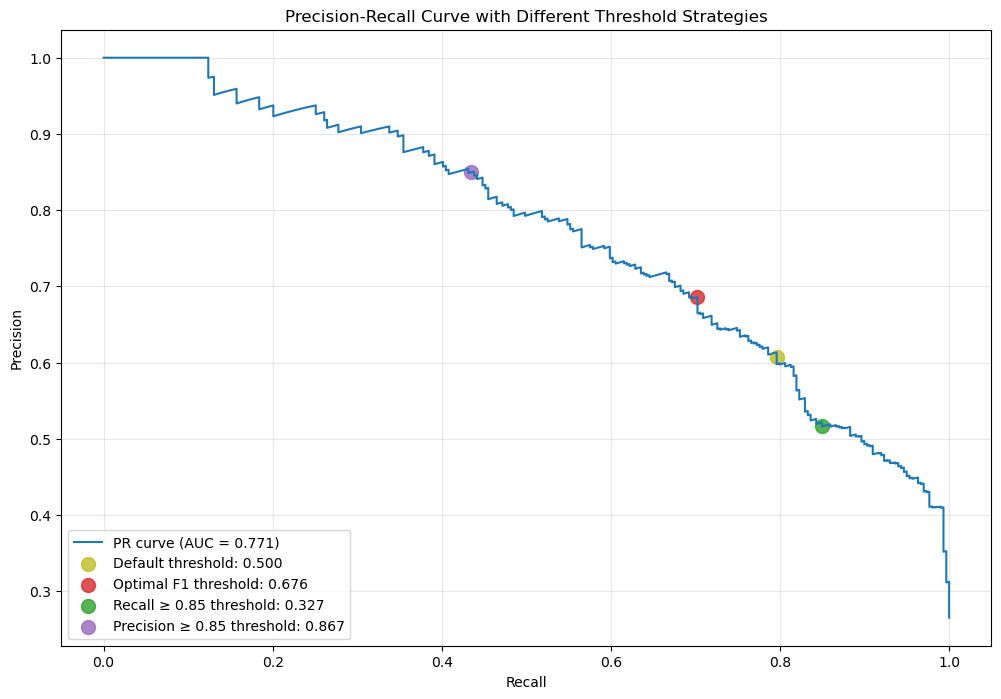

In [44]:
# Plot the precision-recall curve
plt.figure(figsize=(12, 8))
plt.plot(recalls, precisions, label=f"PR curve (AUC = {auc(recalls, precisions):.3f})")

# Find idx for default threshold
default_threshold_idx = np.argmin(np.abs(thresholds - 0.5))

plt.scatter(x=recalls[default_threshold_idx],
            y=precisions[default_threshold_idx],
            color='tab:olive', s=100, alpha=0.8,
            label=f"Default threshold: {default_threshold:.3f}")

plt.scatter(x=recalls[optimal_f1_threshold_idx],
            y=precisions[optimal_f1_threshold_idx],
            color='tab:red', s=100, alpha=0.8,
            label=f"Optimal F1 threshold: {optimal_f1_threshold:.3f}")

plt.scatter(x=recalls[recall_threshold_idx],
            y=precisions[recall_threshold_idx],
            color='tab:green', s=100, alpha=0.8,
            label=f"Recall ≥ 0.85 threshold: {recall_threshold:.3f}")

plt.scatter(x=recalls[precision_threshold_idx],
            y=precisions[precision_threshold_idx],
            color='tab:purple', s=100, alpha=0.8,
            label=f"Precision ≥ 0.85 threshold: {precision_threshold:.3f}")

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve with Different Threshold Strategies')
plt.legend(loc='lower left')
plt.grid(alpha=0.3)
plt.show()

Marking our strategies on the precision-recall curve shows the balancing effect of the optimal F1 threshold as well as the compromises of the recall and precision focused approaches.

## 8. Test Set Evaluation

Now that we've developed and tuned our models, let's evaluate their performance on the held-out test set. This evaluation will provide an unbiased assessment of how well our models will generalize to new, unseen data.

I'll start by cloning the best pipelines and training them on the whole training data.

In [45]:
final_xgb = clone(best_xgb)
final_xgb.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'married',
                                                   'number_of_dependents',
                                                   'number_of_referrals',
                                                   'tenure_in_months',
                                                   'phone_service',
                                                   'avg_monthly_long_distance_charges',
                                                   'multiple_lines',
                                                   'avg_monthly_gb_download',
                                                   'online_security',
                                                   'online_backup',
                                                   'device_protection_plan...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.05,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=5, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=200, n_jobs=-1,
                               num_parallel_tree=None, random_state=42, ...))])

In [46]:
final_svc = clone(best_svc)
final_svc.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'married',
                                                   'number_of_dependents',
                                                   'number_of_referrals',
                                                   'tenure_in_months',
                                                   'phone_service',
                                                   'avg_monthly_long_distance_charges',
                                                   'multiple_lines',
                                                   'avg_monthly_gb_download',
                                                   'online_security',
                                                   'online_backup',
                                                   'device_protection_plan...
                                                   'total_extra_data_charges',
                                                   'cltv', 'streaming',
                                                   'log_total_long_distance_charges',
                                                   'log_total_revenue']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['gender', 'offer',
                                                   'internet_type', 'contract',
                                                   'payment_method'])])),
                ('model',
                 LinearSVC(C=0.1, dual=False, max_iter=6000, penalty='l1',
                           random_state=42))])

### 8.1 Metrics on test set

In [47]:
# XGBoost probabilities
y_test_prob_xgb = final_xgb.predict_proba(X_test)[:, 1]

# XGBoost: Default threshold (0.5)
y_test_pred_xgb_default = (y_test_prob_xgb >= 0.5).astype(int)

# XGBoost: Optimal F1 threshold
y_test_pred_xgb_f1 = (y_test_prob_xgb >= optimal_f1_threshold).astype(int)

# XGBoost: Recall-focused threshold
y_test_pred_xgb_recall = (y_test_prob_xgb >= recall_threshold).astype(int)

# XGBoost: Precision-focused threshold
y_test_pred_xgb_precision = (y_test_prob_xgb >= precision_threshold).astype(int)

# Linear SVC
y_test_pred_svc = final_svc.predict(X_test)

In [48]:
# Create a summary of test performance
test_performance = {
    'XGBoost (Default 0.5)': {
        'F1 Score': f1_score(y_test, y_test_pred_xgb_default),
        'Precision': precision_score(y_test, y_test_pred_xgb_default),
        'Recall': recall_score(y_test, y_test_pred_xgb_default),
        'Accuracy': accuracy_score(y_test, y_test_pred_xgb_default)
    },
    'XGBoost (Optimal F1)': {
        'F1 Score': f1_score(y_test, y_test_pred_xgb_f1),
        'Precision': precision_score(y_test, y_test_pred_xgb_f1),
        'Recall': recall_score(y_test, y_test_pred_xgb_f1),
        'Accuracy': accuracy_score(y_test, y_test_pred_xgb_f1)
    },
    'XGBoost (High Recall)': {
        'F1 Score': f1_score(y_test, y_test_pred_xgb_recall),
        'Precision': precision_score(y_test, y_test_pred_xgb_recall),
        'Recall': recall_score(y_test, y_test_pred_xgb_recall),
        'Accuracy': accuracy_score(y_test, y_test_pred_xgb_recall)
    },
    'XGBoost (High Precision)': {
        'F1 Score': f1_score(y_test, y_test_pred_xgb_precision),
        'Precision': precision_score(y_test, y_test_pred_xgb_precision),
        'Recall': recall_score(y_test, y_test_pred_xgb_precision),
        'Accuracy': accuracy_score(y_test, y_test_pred_xgb_precision)
    },
    'Linear SVC': {
        'F1 Score': f1_score(y_test, y_test_pred_svc),
        'Precision': precision_score(y_test, y_test_pred_svc),
        'Recall': recall_score(y_test, y_test_pred_svc),
        'Accuracy': accuracy_score(y_test, y_test_pred_svc)
    }
}

test_performance_df = pd.DataFrame.from_dict(test_performance, orient='index')
test_performance_df

,F1 Score,Precision,Recall,Accuracy
XGBoost (Default 0.5),0.702517,0.614000,0.820856,0.815472
XGBoost (Optimal F1),0.683646,0.685484,0.681818,0.832505
XGBoost (High Recall),0.672709,0.539580,0.893048,0.769340
XGBoost (High Precision),0.552962,0.841530,0.411765,0.823279
Linear SVC,0.658402,0.678977,0.639037,0.823989


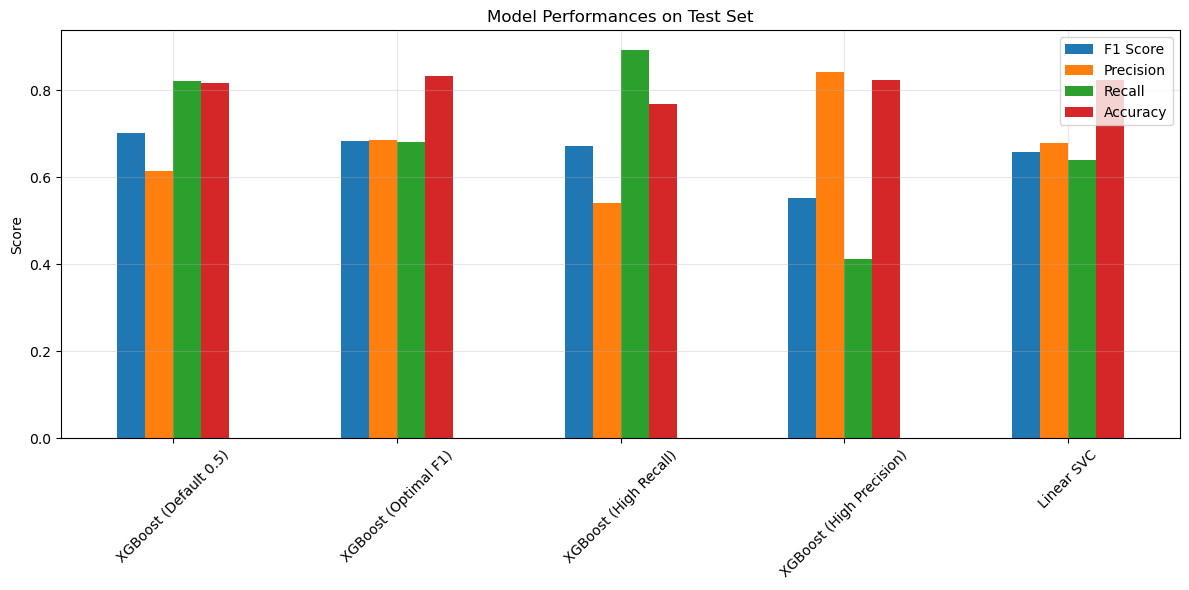

In [49]:
# Plot performance metrics
test_performance_df.plot(kind='bar', figsize=(12, 6))
plt.title('Model Performances on Test Set')
plt.ylabel('Score')
plt.xlabel('')
plt.xticks(rotation=45)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

We can see that performances on the test set are generally similar to the performances on the validation set. Some observations:

- XGBoost with optimal F1 threshold is the best balanced model with very close F1, precision and recall ~68%, and the highest accuracy ~83%. The default threshold version has a slightly (~2%) higher F1 score, but is not balanced between recall and precision.

- Linear SVC is close behind XGBoost with optimal F1 and presents a more straight-forward alternative for the balanced approach, but note that it slightly favors precision ~68% at the cost of lower recall ~64% on the test data.

- High recall XGBoost model has ~89% recall, achieving its task of pushing recall above 85% at the cost of precision.

- High precision model achieves ~84% precision, falling just short of its 85% target, but still provides an option that strongly prioritizes precision over recall.

### 8.2 Confusion Matrices

In [50]:
def plot_all_cms(y_true, y_pred_list, model_names):
    """
    Plots multiple confusion matrices in a 3x2 grid
    """
    fig, axes = plt.subplots(3, 2, figsize=(10, 15))
    axes = axes.flatten()

    for i, (y_pred, model_name) in enumerate(zip(y_pred_list, model_names)):

        cm = confusion_matrix(y_true, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[i])

        # Calculate percentages
        cm_norm_total = cm.astype('float') / cm.sum()
    
        # Add percentages
        for r in range(cm.shape[0]):
            for c in range(cm.shape[1]):
                axes[i].text(
                    c+0.5, r+0.3, f'({cm_norm_total[r,c]:.1%} of total)',
                    ha='center', va='center', color='gray'
                    )
        
        axes[i].set_title(model_name)
        axes[i].set_ylabel('True Label')
        axes[i].set_xlabel('Predicted Label')
        axes[i].set_xticklabels(['No Churn (0)', 'Churn (1)'])
        axes[i].set_yticklabels(['No Churn (0)', 'Churn (1)'])
    
    axes[-1].axis('off')
    plt.tight_layout()
    plt.show()

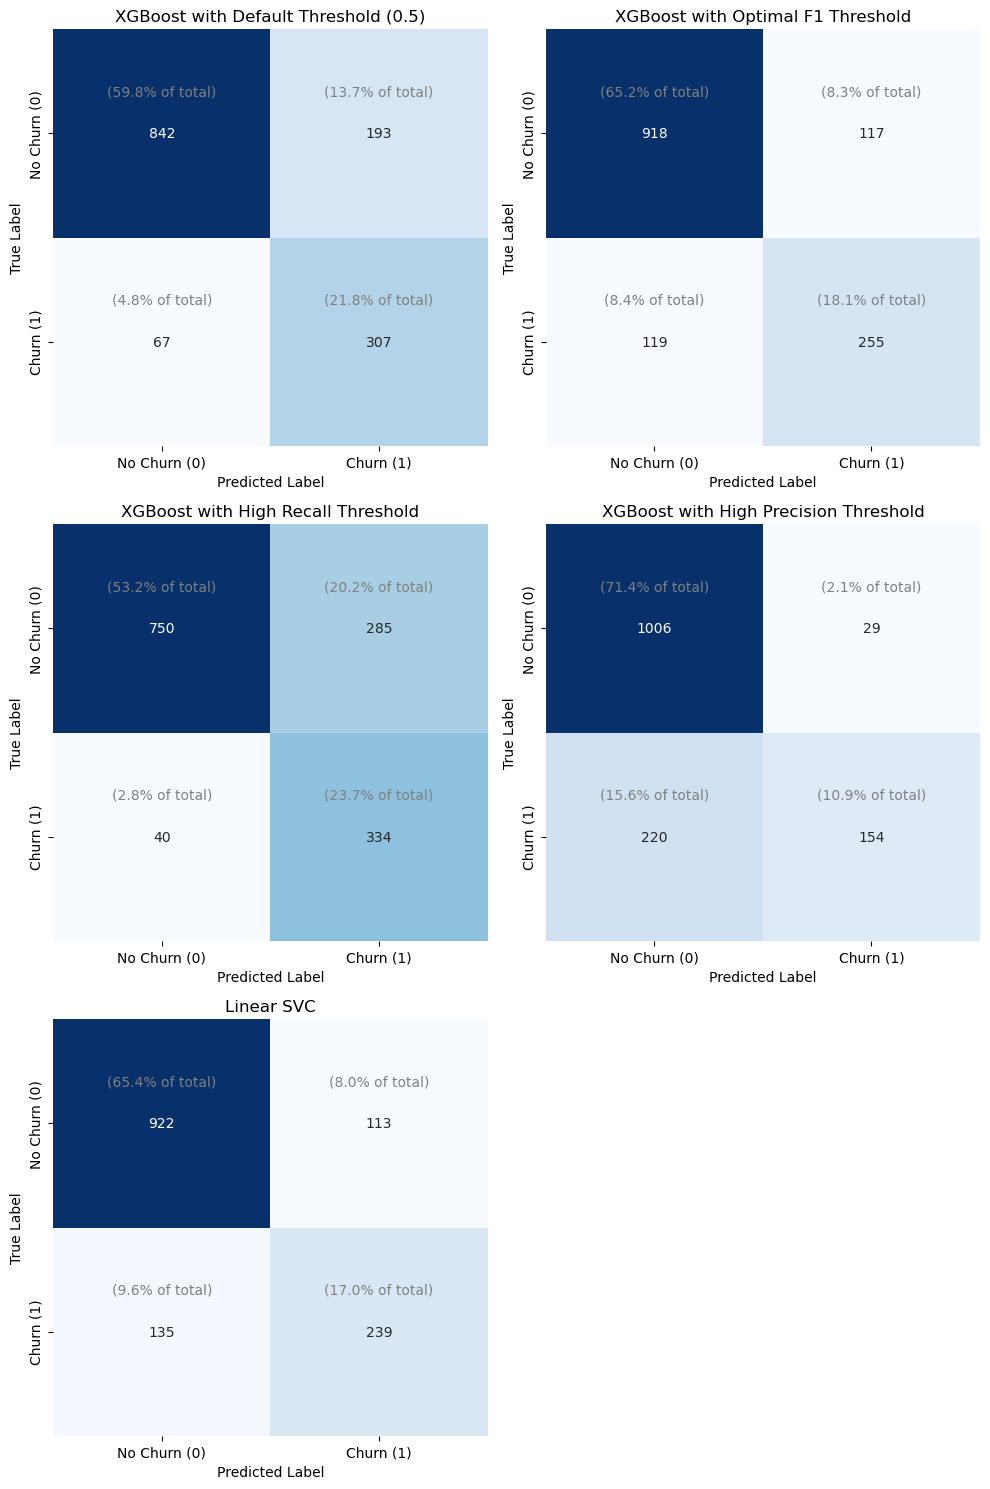

In [51]:
y_pred_list = [
    y_test_pred_xgb_default,
    y_test_pred_xgb_f1,
    y_test_pred_xgb_recall,
    y_test_pred_xgb_precision,
    y_test_pred_svc
]

model_names = [
    "XGBoost with Default Threshold (0.5)",
    "XGBoost with Optimal F1 Threshold",
    "XGBoost with High Recall Threshold",
    "XGBoost with High Precision Threshold",
    "Linear SVC"
]

plot_all_cms(y_test, y_pred_list, model_names)

### 8.3 Classification Reports

In [52]:
# Print classification reports for all models
print("XGBoost with Default Threshold (0.5):")
print(classification_report(y_test, y_test_pred_xgb_default))
print("\n" + "-"*80 + "\n")

print("XGBoost with Optimal F1 Threshold:")
print(classification_report(y_test, y_test_pred_xgb_f1))
print("\n" + "-"*80 + "\n")

print("XGBoost with High Recall Threshold:")
print(classification_report(y_test, y_test_pred_xgb_recall))
print("\n" + "-"*80 + "\n")

print("XGBoost with High Precision Threshold:")
print(classification_report(y_test, y_test_pred_xgb_precision))
print("\n" + "-"*80 + "\n")

print("Linear SVC:")
print(classification_report(y_test, y_test_pred_svc))

XGBoost with Default Threshold (0.5):
              precision    recall  f1-score   support

           0       0.93      0.81      0.87      1035
           1       0.61      0.82      0.70       374

    accuracy                           0.82      1409
   macro avg       0.77      0.82      0.78      1409
weighted avg       0.84      0.82      0.82      1409


--------------------------------------------------------------------------------

XGBoost with Optimal F1 Threshold:
              precision    recall  f1-score   support

           0       0.89      0.89      0.89      1035
           1       0.69      0.68      0.68       374

    accuracy                           0.83      1409
   macro avg       0.79      0.78      0.78      1409
weighted avg       0.83      0.83      0.83      1409


--------------------------------------------------------------------------------

XGBoost with High Recall Threshold:
              precision    recall  f1-score   support

           0    

### 8.4 Precision-Recall Curves and Different Thresholds

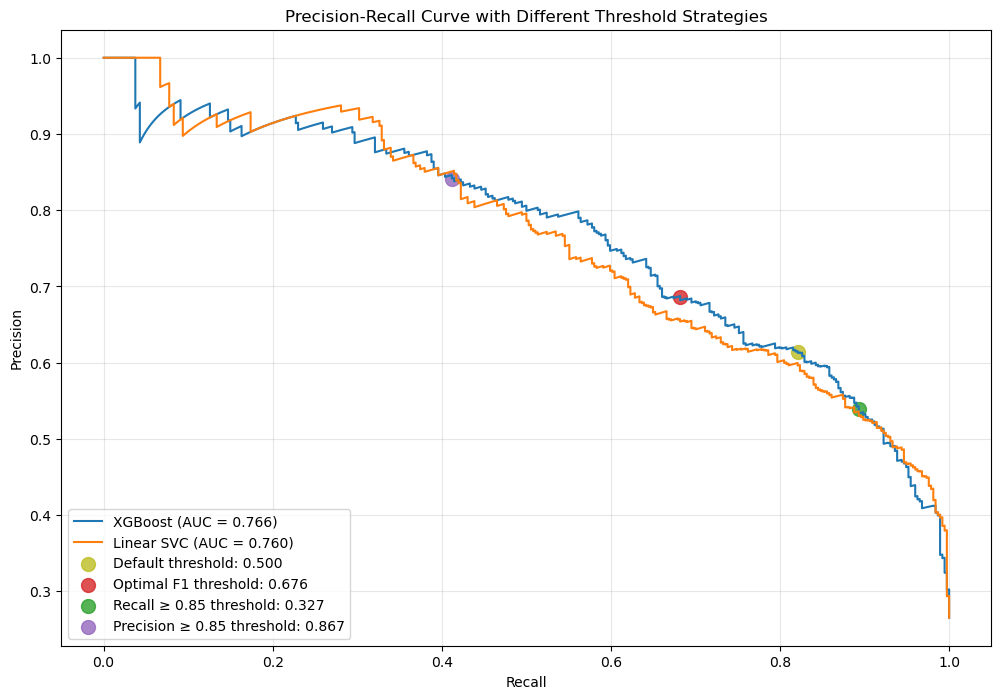

In [53]:
# Plot Precision-Recall curves
plt.figure(figsize=(12, 8))

# Calculate PR curve for XGBoost
precision_xgb, recall_xgb, _ = precision_recall_curve(y_test, y_test_prob_xgb)
pr_auc_xgb = auc(recall_xgb, precision_xgb)
plt.plot(recall_xgb, precision_xgb, 
         label=f'XGBoost (AUC = {pr_auc_xgb:.3f})')

# Get decision function scores for Linear SVC
svc_decision_scores = final_svc.decision_function(X_test)

# Calculate PR curve for Linear SVC
precision_svc, recall_svc, _ = precision_recall_curve(y_test, svc_decision_scores)
pr_auc_svc = auc(recall_svc, precision_svc)
plt.plot(recall_svc, precision_svc, 
         label=f'Linear SVC (AUC = {pr_auc_svc:.3f})')

# Mark different thresholds on the XGBoost PR curve:

# Helper function to find points on the PR curve for specific thresholds
def find_pr_threshold_point(thresh, probs):
    pred = (probs >= thresh).astype(int)
    prec = precision_score(y_test, pred)
    rec = recall_score(y_test, pred)
    return rec, prec

# Default threshold (0.5)
default_recall, default_precision = find_pr_threshold_point(0.5, y_test_prob_xgb)
plt.scatter(default_recall, default_precision,
            color='tab:olive', s=100, alpha=0.8,
            label=f"Default threshold: {default_threshold:.3f}")

# Optimal F1 threshold
f1_recall, f1_precision = find_pr_threshold_point(optimal_f1_threshold, y_test_prob_xgb)
plt.scatter(f1_recall, f1_precision,
            color='tab:red', s=100, alpha=0.8,
            label=f"Optimal F1 threshold: {optimal_f1_threshold:.3f}")

# Recall-focused threshold
recall_recall, recall_precision = find_pr_threshold_point(recall_threshold, y_test_prob_xgb)
plt.scatter(recall_recall, recall_precision,
            color='tab:green', s=100, alpha=0.8,
            label=f"Recall ≥ 0.85 threshold: {recall_threshold:.3f}")

# Precision-focused threshold
precision_recall, precision_precision = find_pr_threshold_point(precision_threshold, y_test_prob_xgb)
plt.scatter(precision_recall, precision_precision,
            color='tab:purple', s=100, alpha=0.8,
            label=f"Precision ≥ 0.85 threshold: {precision_threshold:.3f}")

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve with Different Threshold Strategies')
plt.legend(loc='lower left')
plt.grid(alpha=0.3)
plt.show()

### 8.5 ROC curves of XGBoost and Linear SVC

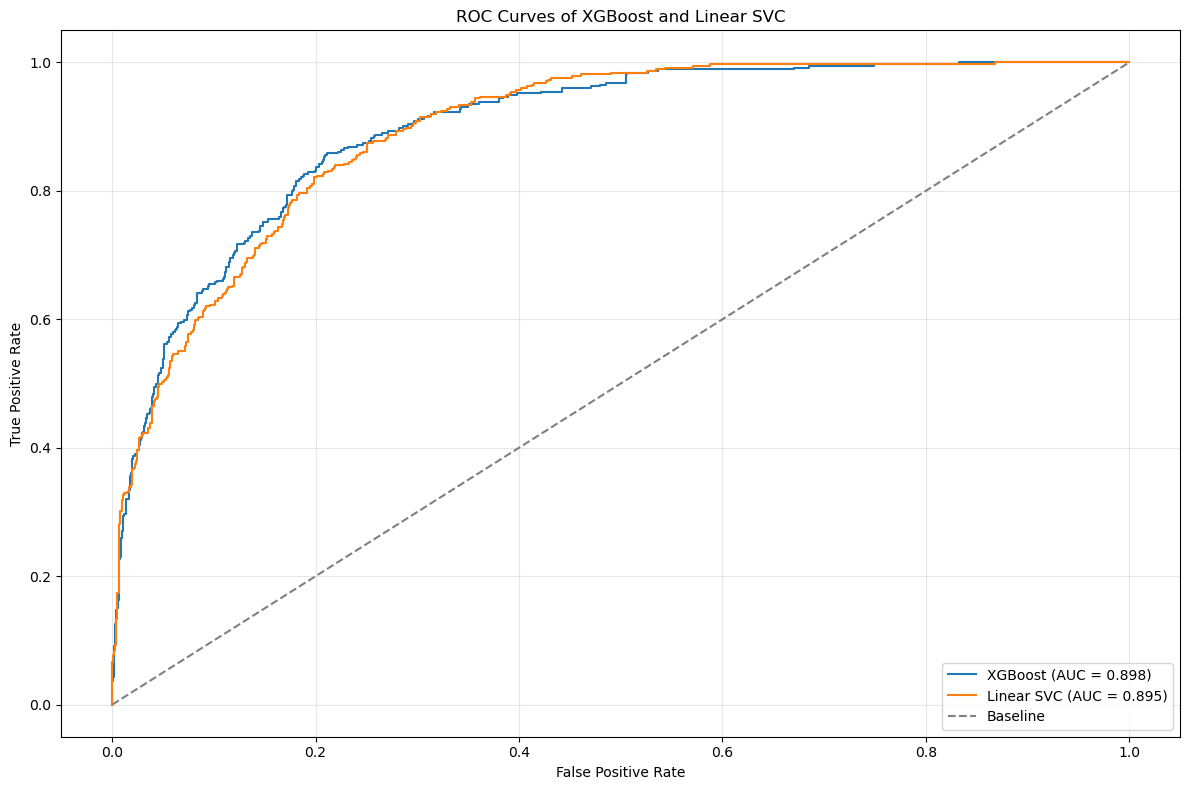

In [54]:
# Plot ROC curves for both models
plt.figure(figsize=(12, 8))

# XGBoost ROC curve
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_test_prob_xgb)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)
plt.plot(fpr_xgb, tpr_xgb, 
         label=f'XGBoost (AUC = {roc_auc_xgb:.3f})')

# Linear SVC ROC curve
fpr_svc, tpr_svc, _ = roc_curve(y_test, svc_decision_scores)
roc_auc_svc = auc(fpr_svc, tpr_svc)
plt.plot(fpr_svc, tpr_svc, 
         label=f'Linear SVC (AUC = {roc_auc_svc:.3f})')

# Plot baseline
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Baseline')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC Curves of XGBoost and Linear SVC")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### 8.6 XGBoost Performance by Threshold

Let's visualize how different threshold values for the XGBoost model affect precision, recall, and F1 score on the test set. This will help understand the trade-offs when selecting different thresholds.

In [55]:
# PR curve for XGBoost calculated again for convenience
precisions, recalls, thresholds = precision_recall_curve(y_test, y_test_prob_xgb)

f1_scores = [
    2 * (p * r) / (p + r) if (p + r) > 0 else 0
    for p, r in zip(precisions[:-1], recalls[:-1])
]

# Find the threshold that gives the maximum F1 score on the test set
max_f1_idx = np.argmax(f1_scores)
test_optimal_f1_threshold = thresholds[max_f1_idx]
max_f1_score = f1_scores[max_f1_idx]

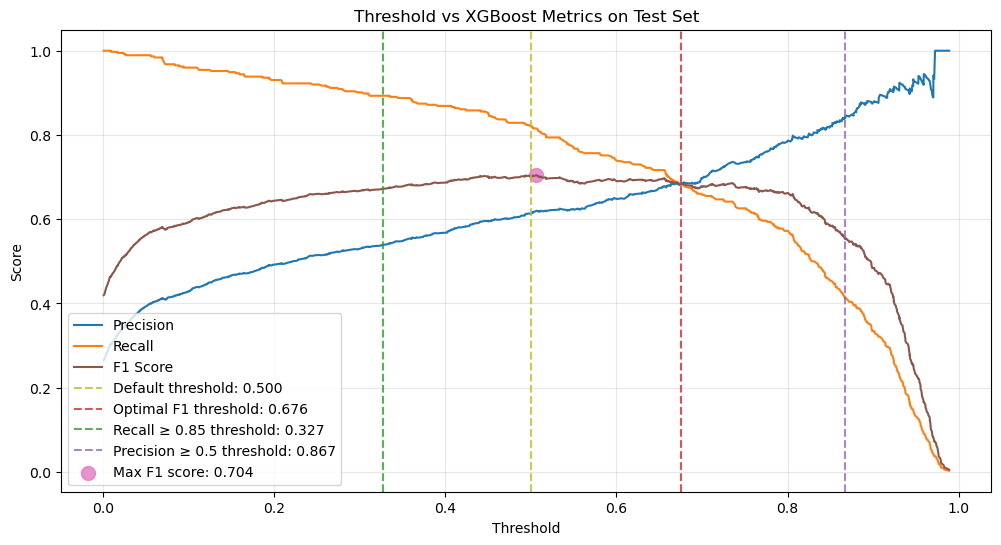

In [56]:
# Plot metrics separately
plt.figure(figsize=(12, 6))
plt.plot(thresholds, precisions[:-1], label='Precision')
plt.plot(thresholds, recalls[:-1], label='Recall')
plt.plot(thresholds, f1_scores, label='F1 Score', color='tab:brown')

plt.axvline(x=default_threshold, color='tab:olive',
            linestyle='--', alpha=0.8,
            label=f"Default threshold: {default_threshold:.3f}")

plt.axvline(x=optimal_f1_threshold, color='tab:red',
            linestyle='--', alpha=0.8,
            label=f"Optimal F1 threshold: {optimal_f1_threshold:.3f}")

plt.axvline(x=recall_threshold, color='tab:green',
            linestyle='--', alpha=0.8,
            label=f"Recall ≥ 0.85 threshold: {recall_threshold:.3f}")

plt.axvline(x=precision_threshold, color='tab:purple',
            linestyle='--', alpha=0.8,
            label=f"Precision ≥ 0.5 threshold: {precision_threshold:.3f}")

# Add a marker at the maximum F1 score point
plt.scatter(test_optimal_f1_threshold, max_f1_score,
            color='tab:pink', s=100, alpha=0.8,
            label=f"Max F1 score: {max_f1_score:.3f}")

plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Threshold vs XGBoost Metrics on Test Set')
plt.legend(loc='lower left')
plt.grid(alpha=0.3)
plt.show()

The optimal F1 threshold does not hit the maximum F1 score on the test set, but it's very close, and it's at the most balanced recall-precision position.

This plot reveals that optimizing for precision hurts recall more dramatically than optimizing for recall hurts precision, which is typical for imbalanced datasets where the minority class (churn at 27%) has fewer examples to learn from. Similarly, F1 optimization with default thresholds tends to favor recall over precision in such imbalanced scenarios.


### 8.7 Conclusion of test evaluation results

- We can safely say that XGBoost with the optimal F1 threshold is the best model for the balanced approach. It generalizes to the test set nicely, giving an F1 score very close to the maximum while maintaining both recall and precision at ~68%. This near-equal balance of precision and recall is a fortunate characteristic of our specific dataset and model, rather than a guaranteed outcome of F1 optimization.

- Linear SVC provides a more straight-forward alternative for the balanced approach, but performs slightly worse on the test set with ~68% precision and ~64% recall.

- XGBoost with high recall threshold successfully achieves the objective of having at least 85% recall with ~89%, demonstrating strong generalization to unseen data.

- The high precision XGBoost version falls slightly short of its 85% target with ~84% precision on the test set, not generalizing quite as well as the high recall model, but still providing substantially better precision compared to other models.

These results provide options for different business scenarios: when balanced performance is needed, when minimizing false negatives is critical (high recall), or when minimizing false positives is the priority (high precision).

## 9. Feature Importance Analysis

In this section, I'll analyze the feature importance of our best models, `final_xgb` and `final_svc`, to understand which factors most strongly contribute to customer churn predictions. This analysis will provide valuable business insights for developing targeted retention strategies.

### 9.1 XGBoost built-in feature importance

XGBoost provides built-in feature importance metrics that are based on how often a feature is used to split the data across all trees and how much those splits improve the model's performance. It focuses on predictive power rather than directional impact.

In order to get the feature names after preprocessing, I'll fit the preprocessor to the training data again. Numerical feature names stay the same, but we need to get the categorical feature names where one-hot encoding was applied.

In [57]:
# Fit the preprocessor to get the transformed feature names
preprocessor.fit(X_train)

# Numerical feature names stay the same
numerical_features = num_features

# Create a mapping from one-hot encoded features to their original feature
feature_mapping = {}
encoded_features = []
for feature in cat_features:
    # Get the categories from the encoder
    categories = preprocessor.named_transformers_['cat'].named_steps['onehot'].categories_[cat_features.index(feature)]
    # Skip the first since we applied drop='first' in OneHotEncoder
    for category in categories[1:]:
        encoded_name = f"{feature}_{category}"
        feature_mapping[encoded_name] = feature
        encoded_features.append(encoded_name)

# Combine all feature names
all_features = numerical_features + encoded_features

In [58]:
# Extract the XGBoost model from the pipeline
xgb_model = final_xgb.named_steps['model']

# Get feature importances from XGBoost
xgb_importance = xgb_model.feature_importances_

# Create a df
xgb_importance_df = pd.DataFrame({
    'Feature': all_features,
    'Importance': xgb_importance
})

xgb_importance_df = xgb_importance_df.sort_values('Importance', ascending=False).reset_index(drop=True)

I'll aggregate categorical features to allow more cohseive understanding of feature importances. My reasoning here is that understanding the impact of contract type is more important than seeing individual contract types split across the importance ranking.

In [59]:
agg_importance_rows = []

# Add numerical features as they are
for feature in numerical_features:
    idx = all_features.index(feature)
    agg_importance_rows.append({
        'Feature': feature,
        'Importance': xgb_importance[idx],
        'Type': 'Numerical'
    })

# Aggregate categorical features
for feature in cat_features:
    # Sum importance of all one-hot encoded features from this category
    total_importance = sum(xgb_importance_df[xgb_importance_df['Feature'].apply(
        lambda x: x.startswith(feature + '_'))]['Importance'])
    
    agg_importance_rows.append({
        'Feature': feature,
        'Importance': total_importance,
        'Type': 'Categorical'
    })

agg_importance_df = pd.DataFrame(agg_importance_rows)
agg_importance_df = agg_importance_df.sort_values('Importance', ascending=False).reset_index(drop=True)

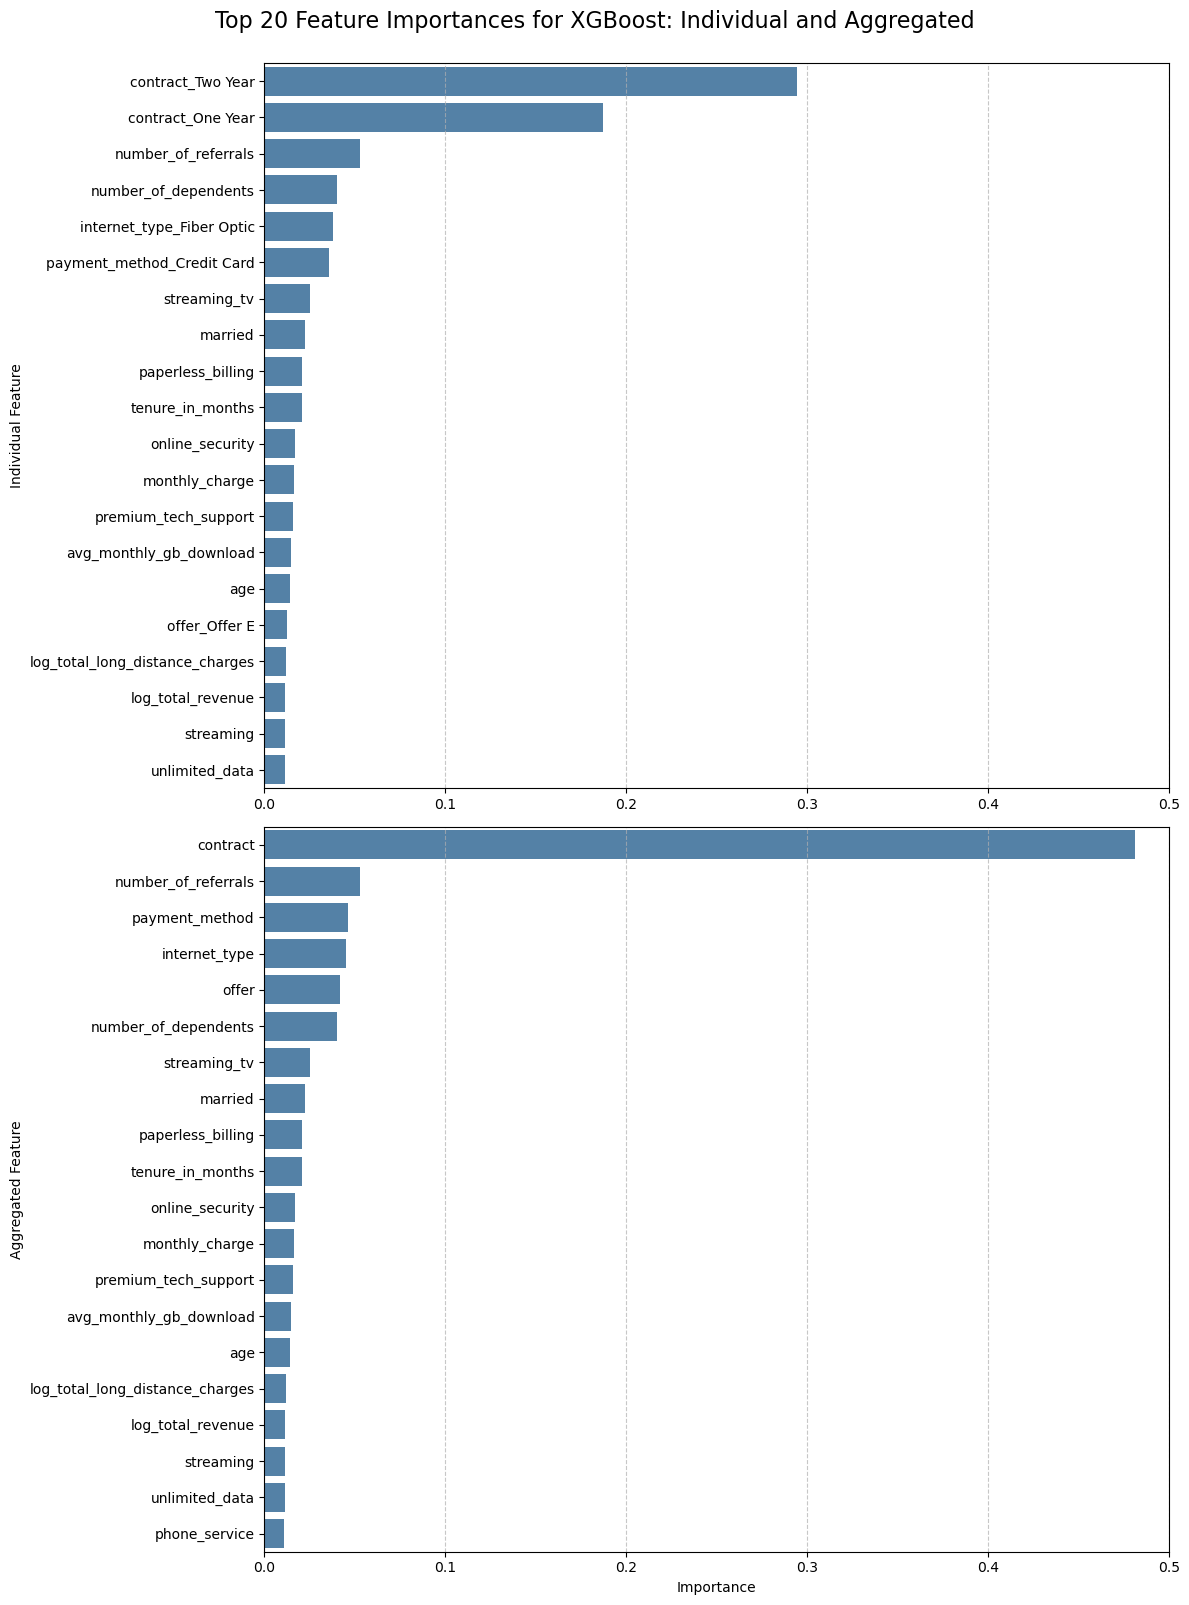

In [60]:
# Plot top n feature importances
n = 20
fig, axes = plt.subplots(2, 1, figsize=(12, 16))

sns.barplot(data=xgb_importance_df.head(n), y='Feature', x='Importance', color='steelblue', ax=axes[0])
axes[0].set_xlabel('')
axes[0].set_ylabel('Individual Feature')
axes[0].set_xlim([0, 0.5])
axes[0].grid(axis='x', linestyle='--', alpha=0.7)

sns.barplot(data=agg_importance_df.head(n), y='Feature', x='Importance', color='steelblue', ax=axes[1])
axes[1].set_xlabel('Importance')
axes[1].set_ylabel('Aggregated Feature')
axes[1].set_xlim([0, 0.5])
axes[1].grid(axis='x', linestyle='--', alpha=0.7)

plt.suptitle(f"Top {n} Feature Importances for XGBoost: Individual and Aggregated", fontsize=16,  y=1)

plt.tight_layout()
plt.show()

#### Key insights from XGBoost feature importance:

Individual Feature Importance:

- Contract type dominates feature importance with two-year contracts having the highest impact, followed by one-year contracts

- Number of referrals is the third most important individual feature

- Number of dependents, fiber optic internet and payment method follow in importance


Aggregated Feature Importance:

- Contract category as a whole is overwhelmingly important

- Number of referrals remains highly influential

- Payment method and internet type categories show significant importance

### 9.2 SHAP values for XGBoost

SHAP values show not just which features matter, but how they impact predictions across different feature values. They reveal both the magnitude and direction of each feature's effect.

In [61]:
def get_stratified_sample(X, y, sample_size=1000):
    """
    Get a stratified sample of data for SHAP
    Uses sklearn's stratified k-fold, hence the need for y
    """
    # If dataset is smaller than sample_size, return everything
    if len(X) <= sample_size:
        return X
    
    stratify_split = StratifiedKFold(
        # Ensure fold size is close to sample_size
        n_splits=max(2, int(len(X) / sample_size)),
        shuffle=True, random_state=42
    )

    # Get indices for the first fold
    train_idx, test_idx = next(stratify_split.split(X, y))

    return X[test_idx]

In [62]:
# Get a stratified sample of data for SHAP analysis
X_test_processed = preprocessor.transform(X_test)
X_sample = get_stratified_sample(X_test_processed, y_test)

# Create a SHAP explainer for the XGBoost model
explainer = shap.Explainer(xgb_model)
shap_values = explainer(X_sample)

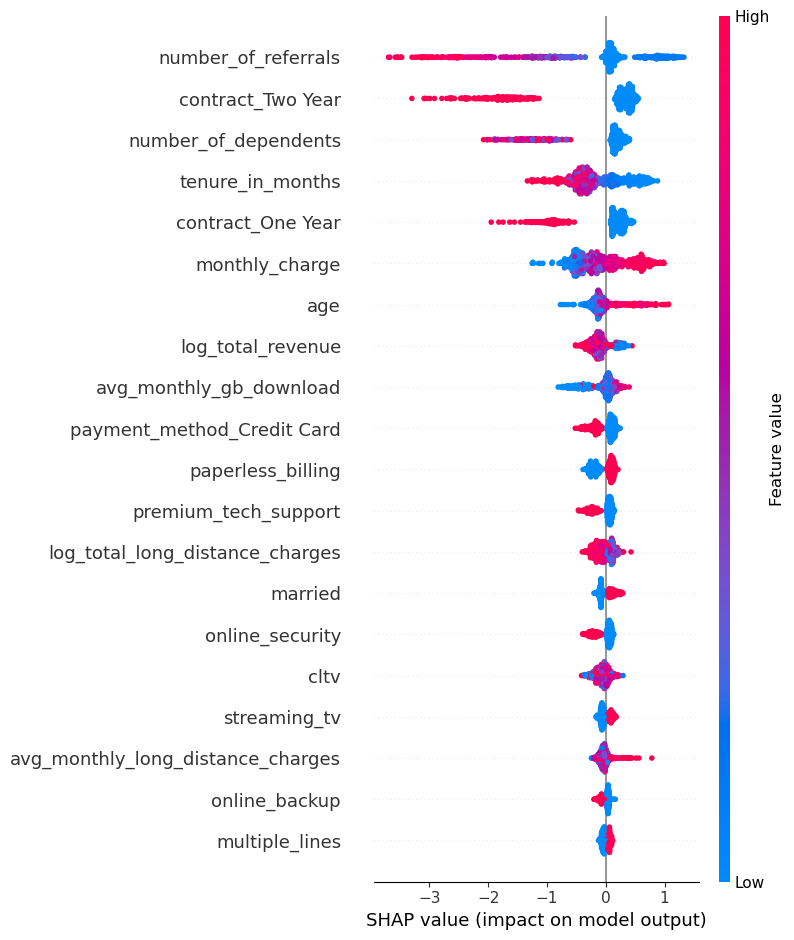

In [63]:
# Summary plot of SHAP values
shap.summary_plot(shap_values, X_sample, feature_names=all_features)

#### Key insights from SHAP values analysis:

- Number of referrals has the highest impact - low values (blue) strongly push predictions toward churn

- Contract length: Two-year contracts strongly reduce churn probability

- Number of dependents: Lower numbers are associated with higher churn

- Tenure: Shorter tenure (blue) is strongly associated with increased churn

- Monthly charge: Higher charges (red) push predictions toward churn

- Age: Younger customers (blue) appear slightly more likely to churn, though there is some variability

#### Number of referrals vs contract type

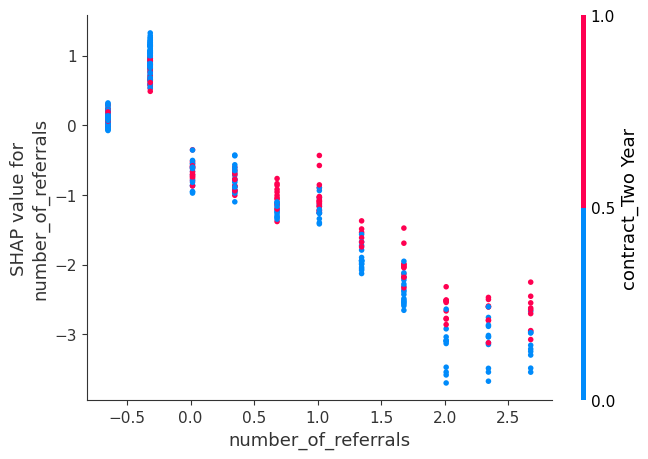

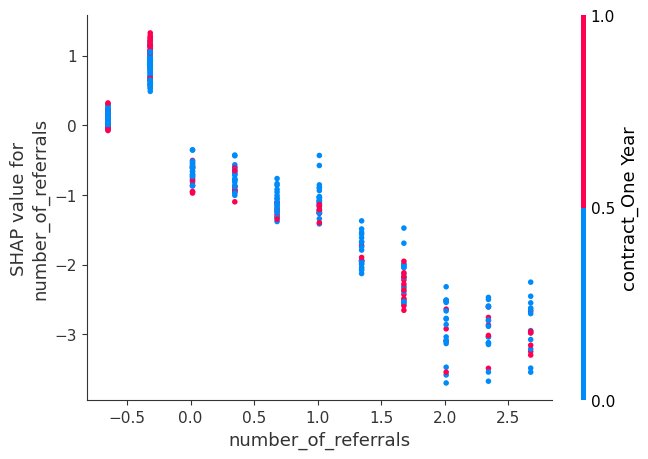

In [64]:
shap.dependence_plot(
    "number_of_referrals", 
    shap_values.values, 
    X_sample,
    feature_names=all_features,
    interaction_index="contract_Two Year"
)

shap.dependence_plot(
    "number_of_referrals", 
    shap_values.values, 
    X_sample,
    feature_names=all_features,
    interaction_index="contract_One Year"
)

We can sse that SHAP contribution becomes increasingly negative as number of referrals increase. The strongest effect is between 0 and 2 referrals.

In the first plot, starting with 1 referral, red points are above blue points, suggesting customers with two year contracts are more likely to churn among customets with multiple referrals.

#### Monthly charge vs contract type

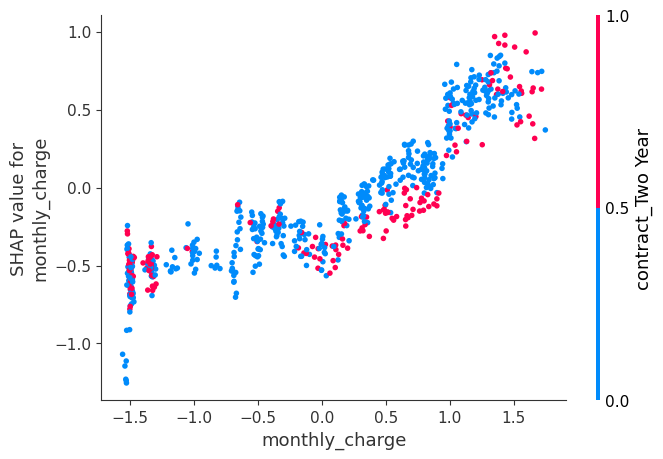

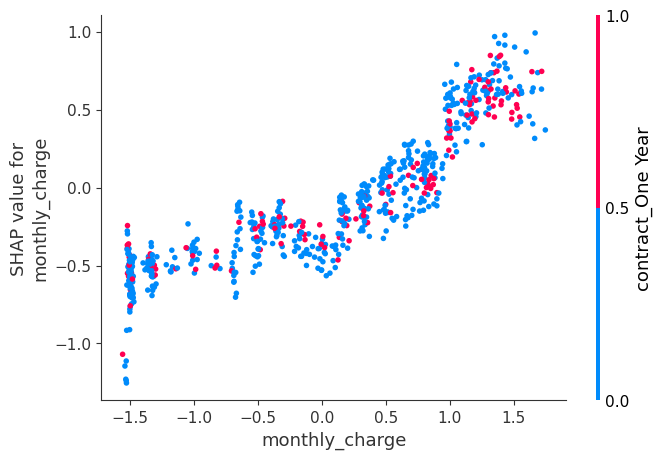

In [65]:
shap.dependence_plot(
    "monthly_charge", 
    shap_values.values, 
    X_sample,
    feature_names=all_features,
    interaction_index="contract_Two Year"
)

shap.dependence_plot(
    "monthly_charge", 
    shap_values.values, 
    X_sample,
    feature_names=all_features,
    interaction_index="contract_One Year"
)

We see a strong positive correlation between monthly charge and its SHAP value, higher charges increase churn possibility, escpecially after the 0.5 mark on the x-axis where the increase starts to get steeper.

In the first plot, we observe red points below blue points between 0 and 1, which makes sense as customers with two-year contracts are less likely to churn in general. But afterwards we see that pattern change which points to price sensitivity even with long contracts.

### 9.3 Linear CVS coefficients

Linear SVC produces coefficients that directly indicate each feature's influence on the decision boundary. These coefficients offer a straightforward interpretation of feature importance and direction of impact.

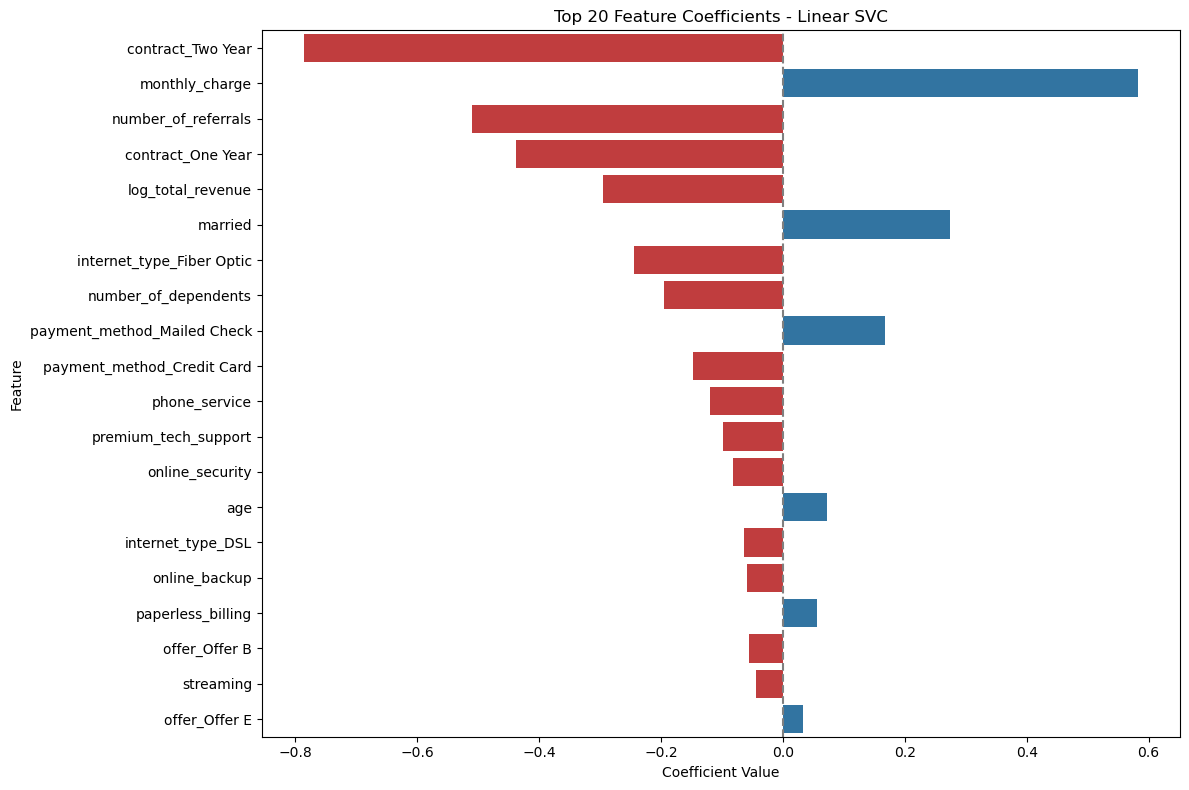

In [66]:
# Extract the Linear SVC model from the final pipeline
svc_model = final_svc.named_steps['model']

# Get coefficients
svc_coefficients = svc_model.coef_[0]

# Create df for coefficient values
svc_coef_df = pd.DataFrame({
    'Feature': all_features,
    'Coefficient': svc_coefficients
})

# Sort by absolute value of coefficients
svc_coef_df['Abs_Coefficient'] = np.abs(svc_coef_df['Coefficient'])
svc_coef_df = svc_coef_df.sort_values('Abs_Coefficient', ascending=False).reset_index(drop=True)

# Plot top n coefficients
n = 20
plt.figure(figsize=(12, 8))
sns.barplot(
    data=svc_coef_df.head(n), 
    y='Feature', 
    x='Coefficient',
    palette=['tab:red' if x < 0 else 'tab:blue' for x in svc_coef_df.head(n)['Coefficient']]
)
plt.title(f'Top {n} Feature Coefficients - Linear SVC')
plt.axvline(x=0, color='gray', linestyle='--')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

#### Key insights from Linear SVC coefficients:

Negative coefficients (red bars) represent features that reduce churn likelihood:

- Strong two-year and one-year contracts are the most protective factors against churn

- Higher number of referrals significantly reduces churn probability

- Higher total revenue (log transformed) indicates customer loyalty

- Having dependents is associated with lower churn rates


Positive coefficients (blue bars) represent features that increase churn likelihood:

- Higher monthly charges show the strongest association with increased churn

- Unmarried customers are more likely to churn

- Customers using mailed checks for payment show higher churn probability

- Age appears to be slightly positively correlated with churn

- Paperless billing shows a small association with increased churn


### 9.4 Comparison of methods and key drivers of churn

In this section, we've used three methods for understanding feature importance:

- XGBoost importance highlights predictive power but doesn't indicate direction of influence
- SHAP values offer the most nuanced insights, revealing how different values of the same feature may have varying impacts
- Linear SVC provides clear directional influence (positive/negative) but may miss complex interactions


#### Consistent Key Drivers Across Models:

1. **Contract Length**: All three methods identify contract length as a critical factor in customer retention. Two-year contracts strongly reduce churn probability, with one-year contracts also showing significant protective effects compared to month-to-month contracts.

2. **Number of Referrals**: Consistently appears as a top predictor across all models. Customers who refer others are demonstrably more loyal, with higher referral counts correlating with lower churn risk.

3. **Monthly Charges**: Higher charges increase churn risk according to both Linear SVC and SHAP analysis, suggesting price sensitivity is a major factor in customer decisions.

4. **Tenure**: While not appearing in Linear SVC's top features, both SHAP and XGBoost identify customer tenure as important. Newer customers are significantly more likely to churn than long-term customers.

5. **Internet Type**: Fiber Optic service shows a strong relationship with churn across methods, suggesting potential issues with this service offering or its pricing structure.

6. **Dependents**: Having dependents (family members on the account) reduces churn probability, indicating family accounts have higher stickiness.


Also, here are a couple interesting findings that emerge from comparing methods:

- **Fiber Optic Service**: While exploratory analysis suggested fiber optic customers had higher churn rates, the Linear SVC showed that after controlling for other factors (especially monthly charges), fiber optic service actually reduced churn probability. This suggests that the observed higher churn may be related to associated pricing rather than service quality issues.

- **Demographic Factors**: The Linear SVC revealed that married status increased churn probability, contradicting some observations in exploratory analysis. This highlights how controlling for multiple variables simultaneously can reveal different patterns than univariate analysis.

## 10. Consolidated results and key findings

In [67]:
# Create a consolidated results table for easy comparison
consolidated_results = pd.DataFrame({
    'Model': [
        'XGBoost (Default 0.5)',
        'XGBoost (Optimal F1)',
        'XGBoost (High Recall)',
        'XGBoost (High Precision)',
        'Linear SVC'
    ],
    'F1 Score': [
        test_performance['XGBoost (Default 0.5)']['F1 Score'],
        test_performance['XGBoost (Optimal F1)']['F1 Score'],
        test_performance['XGBoost (High Recall)']['F1 Score'],
        test_performance['XGBoost (High Precision)']['F1 Score'],
        test_performance['Linear SVC']['F1 Score']
    ],
    'Precision': [
        test_performance['XGBoost (Default 0.5)']['Precision'],
        test_performance['XGBoost (Optimal F1)']['Precision'],
        test_performance['XGBoost (High Recall)']['Precision'],
        test_performance['XGBoost (High Precision)']['Precision'],
        test_performance['Linear SVC']['Precision']
    ],
    'Recall': [
        test_performance['XGBoost (Default 0.5)']['Recall'],
        test_performance['XGBoost (Optimal F1)']['Recall'],
        test_performance['XGBoost (High Recall)']['Recall'],
        test_performance['XGBoost (High Precision)']['Recall'],
        test_performance['Linear SVC']['Recall']
    ],
    'Accuracy': [
        test_performance['XGBoost (Default 0.5)']['Accuracy'],
        test_performance['XGBoost (Optimal F1)']['Accuracy'],
        test_performance['XGBoost (High Recall)']['Accuracy'],
        test_performance['XGBoost (High Precision)']['Accuracy'],
        test_performance['Linear SVC']['Accuracy']
    ],
    'Business Use Case': [
        'General purpose',
        'Balanced approach',
        'Minimize missed churners',
        'Minimize false alarms',
        'Simple, interpretable model'
    ]
})

# Display the consolidated results
consolidated_results.set_index('Model', inplace=True)
consolidated_results.style.background_gradient(cmap='Blues', subset=['F1 Score', 'Precision', 'Recall', 'Accuracy'])

,F1 Score,Precision,Recall,Accuracy,Business Use Case
Model,,,,,
XGBoost (Default 0.5),0.702517,0.614000,0.820856,0.815472,General purpose
XGBoost (Optimal F1),0.683646,0.685484,0.681818,0.832505,Balanced approach
XGBoost (High Recall),0.672709,0.539580,0.893048,0.769340,Minimize missed churners
XGBoost (High Precision),0.552962,0.841530,0.411765,0.823279,Minimize false alarms
Linear SVC,0.658402,0.678977,0.639037,0.823989,"Simple, interpretable model"


#### Summary of Key Findings

Our analysis has yielded several important insights:

1. **Model Performance**: Our best-performing model, XGBoost with custom threshold for optimal F1, achieves an F1 score ~68% on the test set, with balanced precision and recall.

2. **Flexibility Through Threshold Adjustment**: By adjusting probability thresholds, we've developed variants of our XGBoost model that can be adapted to different business perspectives without retraining:

   - We've calibrated the model to achieve the following specific targets:
      - Balanced performance (~68% precision and recall) through F1 optimization, which in this case fortunately resulted in nearly identical precision and recall values
      - High-recall configuration (~89%) to catch most potential churners
      - High-precision configuration (~84%) to minimize false positives

   - This provides a dynamic approach to precision-recall trade-off; the probability threshold can be modified according to changing business conditions.

3. **Simplicity vs. Performance for Balanced Model**: While XGBoost offers the best performance and business flexibility, Linear SVC provides nearly comparable results for the balanced approach with greater simplicity and transparency.

4. **Key Churn Drivers and Analytical Insights**: We've used three feature importance methods and identified several critical factors influencing customer churn:

   - **Contract type**: The data shows significantly higher churn probability for month-to-month contracts compared to one or two-year commitments, suggesting that customer flexibility directly impacts retention
   
   - **Referral behavior**: Each additional referral correlates with substantially reduced churn risk, indicating that referral activity serves as both an indicator of satisfaction and a potential engagement mechanism
   
   - **Monthly charges**: Higher charges correlate with increased churn probability even after controlling for services received, revealing price sensitivity thresholds that could be further analyzed
   
   - **Tenure**: Newer customers demonstrate significantly higher churn probability, with the first 12 months representing a critical window for retention
   
   - **Internet service type**: Fiber optic service shows a complex relationship with churn that warrants deeper investigation into service quality and value perception
   
   - **Household composition**: Accounts with dependents show lower churn rates, suggesting that family-oriented services create stronger customer relationships

## 11. Conclusion and future work

In this project, I've developed a churn prediction framework for a telecommunications company, using [IBM's sample datasets](https://accelerator.ca.analytics.ibm.com/bi/?perspective=authoring&pathRef=.public_folders%2FIBM%2BAccelerator%2BCatalog%2FContent%2FDAT00148&id=i9710CF25EF75468D95FFFC7D57D45204&objRef=i9710CF25EF75468D95FFFC7D57D45204&action=run&format=HTML&cmPropStr=%7B%22id%22%3A%22i9710CF25EF75468D95FFFC7D57D45204%22%2C%22type%22%3A%22reportView%22%2C%22defaultName%22%3A%22DAT00148%22%2C%22permissions%22%3A%5B%22execute%22%2C%22read%22%2C%22traverse%22%5D%7D). Our analysis reveals that contract type, number of referrals, monthly charges, tenure, internet service type, and dependents are the most critical factors influencing customer churn.

We've used a dynamic threshold adjustment approach to optimize our best performing XGBoost model for different business objectives: balanced performance through F1 optimization (which coincidentally yielded nearly identical precision and recall values in our case), high recall, or high precision depending on business needs.

Working with our imbalanced dataset (27% churn) revealed an important insight: Optimizing for precision hurts recall more dramatically than vice versa due to the minority class having fewer examples. This asymmetry explains why default F1 optimization often favors recall, and demonstrates why explicit threshold adjustment after training is essential for achieving truly balanced performance. The complementary nature of hyperparameter tuning and threshold adjustment is crucial for effectively handling this imbalanced classification problem.

#### Limtations

- We have identified factors associated with churn, but not necessarily causal relationships.

- Our analysis uses a static approach without any time-series data, and wouldn't capture the nature of customer behavior over time.

#### Future work

- Cost-benefit analysis for the impact of retention strategies

- Designing controlled experiments to apply A/B testing on the effectiveness of specific intervention techniques